In [71]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from IPython.core.pylabtools import figsize

# --- 1. Material Definitions ---
# Using fixed indices for 1550nm for simplicity

wavelength =  1.55                              # Central wavelength
wv_points = 50                   # number of wavelength wv_points
width_220 = 0.390
width_300 = 0.310               # Anchos optimizados para tener single mode regimen
MMI_L_points = 4
MMI_W_points = 4
n_si = 3.475
n_sio2 = 1.458
MMI_L_optimized = 7.8
MMI_W_optimized = 3
taper_width = 0.8
Initial_pos = -11



sweep_wavelength = np.linspace(1.5,1.6,wv_points)  # Sweep on wavelengths
sweep_freq = td.C_0 / sweep_wavelength          # Sweep on Frequencies
sweep_MMI_L = np.linspace(MMI_L_optimized-0.3,MMI_L_optimized+0.3,MMI_L_points)
sweep_MMI_W = np.linspace(MMI_W_optimized-0.15,MMI_W_optimized+0.15,MMI_W_points)
dinstance_tapers = sweep_MMI_W/2


# Para calculo de tolerancia

MMI_L_points_tol = 2
MMI_W_points_tol = 2

sweep_MMI_L_tol = np.linspace(MMI_L_optimized-0.05,MMI_L_optimized+0.05,MMI_L_points_tol)
sweep_MMI_W_tol = np.linspace(MMI_W_optimized-0.01,MMI_W_optimized+0.01,MMI_W_points_tol)
dinstance_tapers_tol = sweep_MMI_W_tol/2


bandwidth = sweep_wavelength[-1]-sweep_wavelength[0]

mat_si = td.material_library["cSi"]["Li1993_293K"] # Material trace permitivity model for crystaline Silicon
mat_sio2 = td.material_library["SiO2"]["Horiba"]   # Material trace permitivity model for crystaline Silica


web.configure("U7IS5Q1AW3qYVxPAAQDE7vgxaTz6Kt6aI9AioPZUajVRQQ2o")

Configuration saved successfully.


In [72]:
def build_MMI_simulation(
    MMI_length = np.array([MMI_L_optimized]),
    MMI_width = np.array([MMI_W_optimized]),
    width_single_mode=np.array([width_220,width_300]),
    thickness=np.array([0.22,0.3]),
    wavelength = np.array([1.55]),
    dinstance_tapers = np.array([MMI_W_optimized])
):

    # Frequency
    freq = td.C_0 / wavelength

    # Materials
    core = mat_si
    clad = mat_sio2

    # --- We define the simulation data array and simulation objects for the two different sweeps----

    sim_data_arr = [[[]],[[]]] # Simulation data for 220nm and 300nm, Length sweep and Width sweep
    sim_arr = [[[]],[[]]]      # Simulation objects for 220nm and 300nm , Length sweep and Width sweep
    estimate = 0

    #--- Define Sources ---
    freq0 = td.C_0 / wavelength.mean()
    fwidth = (td.C_0 / wavelength.min()) - (td.C_0 / wavelength.max())



    for (thick_idx,thick) in enumerate(thickness):
        for (length_idx,length_values) in enumerate(MMI_length):
            for (width_idx,width_values) in enumerate(MMI_width):

                ## Definicion de la fuente ##
                source1 = td.ModeSource(
                    name = 'Mode_source',
                    center = [Initial_pos-3.5, 0, 0],
                    size = [0, 4, 4],
                    source_time = td.GaussianPulse(freq0 = freq0, fwidth = fwidth, ),
                    direction = '+',
                    mode_spec = td.ModeSpec(num_modes = 1, target_neff = n_si, sort_spec = {'filter_reference' : 0, 'filter_order':'over', 'sort_order':'ascending', 'track_freq':'central'}, group_index_step = True, ),
                )

                ## Definicion de los monitores ##

                Longitudinal = td.FieldMonitor(
                    name = 'Longitudinal',
                    size = [td.inf, 7.75, 0],
                    freqs = freq,
                )

                IN = td.FieldMonitor(
                    name = 'IN',
                    center = [Initial_pos-2.5, 0, 0],
                    size = [0, 4, 4],
                    freqs = freq,
                )

                OUT1 = td.FieldMonitor(
                    name = 'OUT1',
                    center = [length_values + Initial_pos + 3, dinstance_tapers[width_idx] / 2, 0],
                    size = [0, 1, 1],
                    freqs = freq,
                )

                OUT2 = td.FieldMonitor(
                    name = 'OUT2',
                    center = [length_values + Initial_pos + 3, -dinstance_tapers[width_idx] / 2, 0],
                    size = [0, 1, 1],
                    freqs = freq,
                )


                ## Definicion de las estructuras ##


                ## For a Strip
                Xmin_Strip= (-100)
                Xmax_Strip= (-2+Initial_pos)

                Ymin_Strip= (-width_single_mode[thick_idx]/2)
                Ymax_Strip= (width_single_mode[thick_idx]/2)

                Zmin_Strip= (-thick/2)
                Zmax_Strip= (thick/2)

                Strip = td.Structure(
                    geometry = td.Box(center = [(Xmax_Strip+Xmin_Strip)/2, (Ymax_Strip+Ymin_Strip)/2, (Zmax_Strip+Zmin_Strip)/2], size = [Xmax_Strip-Xmin_Strip, Ymax_Strip-Ymin_Strip, Zmax_Strip-Zmin_Strip], ),
                    name = 'Strip',
                    medium = core
                )



                 ## For the MMI

                Xmin_MMI= Initial_pos
                Xmax_MMI= length_values+Initial_pos

                Ymin_MMI= -width_values/2
                Ymax_MMI= width_values/2

                Zmin_MMI= (-thick/2)
                Zmax_MMI= (thick/2)

                MMI = td.Structure(
                    geometry = td.Box(center = [(Xmax_MMI+Xmin_MMI)/2, (Ymax_MMI+Ymin_MMI)/2, (Zmax_MMI+Zmin_MMI)/2], size = [Xmax_MMI-Xmin_MMI, Ymax_MMI-Ymin_MMI, Zmax_MMI-Zmin_MMI]),
                    name = 'MMI',
                    medium = core
                )


                ## For the Taper In

                Xv1_Taper_IN =-2+Initial_pos
                Yv1_Taper_IN =-width_single_mode[thick_idx]/2

                Xv2_Taper_IN = Initial_pos
                Yv2_Taper_IN =-taper_width/2

                Xv3_Taper_IN = Initial_pos
                Yv3_Taper_IN = taper_width/2

                Xv4_Taper_IN = -2 + Initial_pos
                Yv4_Taper_IN = width_single_mode[thick_idx] / 2

                Zmin_Taper_IN= (-thick/2)
                Zmax_Taper_IN= (thick/2)


                Taper_IN = td.Structure(
                    geometry = td.PolySlab(slab_bounds = [Zmin_Taper_IN, Zmax_Taper_IN], vertices = [[Xv1_Taper_IN, Yv1_Taper_IN], [Xv2_Taper_IN, Yv2_Taper_IN], [Xv3_Taper_IN, Yv3_Taper_IN], [Xv4_Taper_IN, Yv4_Taper_IN]]),
                    name = 'Taper',
                    medium = core
                )

                 ## For the Taper OUT 1

                Xv1_Taper_OUT_1 = length_values+Initial_pos+2
                Yv1_Taper_OUT_1 =-width_single_mode[thick_idx]/2-dinstance_tapers[width_idx]/2

                Xv2_Taper_OUT_1 = length_values+Initial_pos
                Yv2_Taper_OUT_1 =-dinstance_tapers[width_idx]/2-taper_width/2

                Xv3_Taper_OUT_1 = length_values+Initial_pos
                Yv3_Taper_OUT_1 = -dinstance_tapers[width_idx]/2+taper_width/2

                Xv4_Taper_OUT_1 = length_values+Initial_pos+2
                Yv4_Taper_OUT_1 = -dinstance_tapers[width_idx]/2+width_single_mode[thick_idx]/2

                Zmin_Taper_OUT_1= (-thick/2)
                Zmax_Taper_OUT_1= (thick/2)



                Taper_out1 = td.Structure(
                    geometry = td.PolySlab(slab_bounds = [Zmin_Taper_OUT_1, Zmax_Taper_OUT_1], vertices = [[Xv1_Taper_OUT_1, Yv1_Taper_OUT_1], [Xv2_Taper_OUT_1, Yv2_Taper_OUT_1], [Xv3_Taper_OUT_1, Yv3_Taper_OUT_1], [Xv4_Taper_OUT_1, Yv4_Taper_OUT_1]]),
                    name = 'Taper_out1',
                    medium = core
                )


                ## For the Taper OUT 2

                Xv1_Taper_OUT_2 = length_values+Initial_pos+2
                Yv1_Taper_OUT_2 =width_single_mode[thick_idx]/2+dinstance_tapers[width_idx]/2

                Xv2_Taper_OUT_2 = length_values+Initial_pos
                Yv2_Taper_OUT_2 =dinstance_tapers[width_idx]/2+taper_width/2

                Xv3_Taper_OUT_2 = length_values+Initial_pos
                Yv3_Taper_OUT_2 = dinstance_tapers[width_idx]/2-taper_width/2

                Xv4_Taper_OUT_2 = length_values+Initial_pos+2
                Yv4_Taper_OUT_2 = dinstance_tapers[width_idx]/2-width_single_mode[thick_idx]/2

                Zmin_Taper_OUT_2= (-thick/2)
                Zmax_Taper_OUT_2= (thick/2)


                Taper_out2 = td.Structure(
                    geometry = td.PolySlab(slab_bounds = [Zmin_Taper_OUT_2, Zmax_Taper_OUT_2], vertices = [[Xv1_Taper_OUT_2, Yv1_Taper_OUT_2], [Xv2_Taper_OUT_2, Yv2_Taper_OUT_2], [Xv3_Taper_OUT_2, Yv3_Taper_OUT_2], [Xv4_Taper_OUT_2, Yv4_Taper_OUT_2]]),
                    name = 'Taper_out2',
                    medium = core
                )


                ## for a Strip_out1

                Xmin_Strip_out1= length_values+Initial_pos+2
                Xmax_Strip_out1= length_values+100

                Ymin_Strip_out1= -dinstance_tapers[width_idx]/2-width_single_mode[thick_idx]/2
                Ymax_Strip_out1= width_single_mode[thick_idx]/2-dinstance_tapers[width_idx]/2

                Zmin_Strip_out1= (-thick/2)
                Zmax_Strip_out1= (thick/2)



                Strip_out1 = td.Structure(
                    geometry = td.Box(center = [(Xmax_Strip_out1+Xmin_Strip_out1)/2, (Ymax_Strip_out1+Ymin_Strip_out1)/2, (Zmax_Strip_out1+Zmin_Strip_out1)/2], size = [Xmax_Strip_out1-Xmin_Strip_out1, Ymax_Strip_out1-Ymin_Strip_out1, Zmax_Strip_out1-Zmin_Strip_out1]),
                    name = 'Strip_out1',
                    medium = core
                )

                ## for a Strip_out2

                Xmin_Strip_out2= length_values+Initial_pos+2
                Xmax_Strip_out2= length_values+100

                Ymin_Strip_out2= dinstance_tapers[width_idx]/2-width_single_mode[thick_idx]/2
                Ymax_Strip_out2= width_single_mode[thick_idx]/2+dinstance_tapers[width_idx]/2

                Zmin_Strip_out2= (-thick/2)
                Zmax_Strip_out2= (thick/2)


                Strip_out2 = td.Structure(
                    geometry = td.Box(center = [(Xmax_Strip_out2+Xmin_Strip_out2)/2, (Ymax_Strip_out2+Ymin_Strip_out2)/2, (Zmax_Strip_out2+Zmin_Strip_out2)/2], size = [Xmax_Strip_out2-Xmin_Strip_out2, Ymax_Strip_out2-Ymin_Strip_out2, Zmax_Strip_out2-Zmin_Strip_out2]),
                    name = 'Strip_out2',
                    medium = core
                )#Hasta aca todo bien



                # --- Simulation domain ---
                sim_arr[thick_idx][length_idx].append(td.Simulation(
                    center = [-3.5, 0, 0],
                    size=[23, 6, 6],  # x ignored for mode solver
                    monitors=[OUT1,OUT2,Longitudinal,IN],
                    sources=[source1],
                    structures=[Strip,Strip_out1,Strip_out2,MMI,Taper_IN,Taper_out1,Taper_out2],
                    medium=clad,
                    symmetry=(0, 0, 1),  # symmetry in z
                    run_time = {'quality_factor' : 1, 'source_factor' : 3},
                    grid_spec=td.GridSpec.auto(wavelength = wavelength.min(),min_steps_per_wvl = 11),
                ))

                Job = web.Job(simulation=sim_arr[thick_idx][length_idx][width_idx], task_name="my_sim")

                estimate+= Job.estimate_cost()

                sim_data_arr[thick_idx][length_idx].append(web.run(sim_arr[thick_idx][length_idx][width_idx], task_name='DC_FDTD'))

            sim_data_arr[thick_idx].append([])
            sim_arr[thick_idx].append([])

    print(f"Estimated Maximum Cost: {estimate}")

    return sim_data_arr, sim_arr


sim_data, sim = build_MMI_simulation(MMI_length = sweep_MMI_L,MMI_width=sweep_MMI_W,wavelength=sweep_wavelength, dinstance_tapers = dinstance_tapers)

20:21:17 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-d78b84ff-dcd5-4252-9448-1fd3cbae0b
                                        c0' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=202311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d78b84ff-dcd5-4252-9448-1fd3cbae0bc0\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=202311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d78b84ff-dcd5-4252-9448-1fd3cbae0bc0\ch?]8;;\]8;id=972626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d78b84ff-dcd5-4252-9448-1fd3cbae0bc0\taskId]8;;\]8;id=202311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d78b84ff-dcd5-4252-9448-1fd3cbae0bc0\=]8;;\]8;id=52761;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d78b84ff-dcd5-4252-9448-1fd3cbae0bc0\fdve]8;;\]8;id=202311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d78b84ff-dcd5-4252-9448-1fd3cbae0bc0\-d78b84ff-dcd5-4252-9448-1]8;;\
                                        ]8;id=202311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d78b84ff-dcd5-4252-9448-1fd3cbae0bc0\fd3cbae0bc0']8;;\.

                                        Task folder: ]8;id=764636;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:21:21 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186
                                        df' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=133730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=133730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\ch?]8;;\]8;id=548654;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\taskId]8;;\]8;id=133730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\=]8;;\]8;id=954095;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\fdve]8;;\]8;id=133730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\-5c0d0d4a-2f50-4722-b2fb-e]8;;\
                                        ]8;id=133730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\26ad99186df']8;;\.

                                        Task folder: ]8;id=499169;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:21:23 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:21:25 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:21:33 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:21:51 Hora est. Pacífico, Sudamérica status = postprocess

20:21:56 Hora est. Pacífico, Sudamérica status = success

20:21:58 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=276468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=276468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\ch?]8;;\]8;id=133723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\taskId]8;;\]8;id=276468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\=]8;;\]8;id=296153;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\fdve]8;;\]8;id=276468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\-5c0d0d4a-2f50-4722-b2fb-e]8;;\
                                        ]8;id=276468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c0d0d4a-2f50-4722-b2fb-e26ad99186df\26ad99186df']8;;\.

20:22:07 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.00018 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-3178f606-db17-4e73-84bc-7ea38b6449
                                        13' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=400697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3178f606-db17-4e73-84bc-7ea38b644913\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=400697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3178f606-db17-4e73-84bc-7ea38b644913\ch?]8;;\]8;id=894609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3178f606-db17-4e73-84bc-7ea38b644913\taskId]8;;\]8;id=400697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3178f606-db17-4e73-84bc-7ea38b644913\=]8;;\]8;id=247566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3178f606-db17-4e73-84bc-7ea38b644913\fdve]8;;\]8;id=400697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3178f606-db17-4e73-84bc-7ea38b644913\-3178f606-db17-4e73-84bc-7]8;;\
                                        ]8;id=400697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3178f606-db17-4e73-84bc-7ea38b644913\ea38b644913']8;;\.

                                        Task folder: ]8;id=431965;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:22:11 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e3
                                        23' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=89175;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=89175;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\ch?]8;;\]8;id=639653;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\taskId]8;;\]8;id=89175;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\=]8;;\]8;id=931485;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\fdve]8;;\]8;id=89175;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\-975359c7-77d8-474b-9d4b-2]8;;\
                                        ]8;id=89175;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\bf1e7a5e323']8;;\.

                                        Task folder: ]8;id=321122;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:22:14 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:22:15 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:22:23 Hora est. Pacífico, Sudamérica starting up solver

20:22:24 Hora est. Pacífico, Sudamérica running solver

20:22:39 Hora est. Pacífico, Sudamérica status = postprocess

20:22:45 Hora est. Pacífico, Sudamérica status = success

20:22:47 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=665411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=665411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\ch?]8;;\]8;id=484532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\taskId]8;;\]8;id=665411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\=]8;;\]8;id=289793;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\fdve]8;;\]8;id=665411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\-975359c7-77d8-474b-9d4b-2]8;;\
                                        ]8;id=665411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-975359c7-77d8-474b-9d4b-2bf1e7a5e323\bf1e7a5e323']8;;\.

20:23:02 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:23:03 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00039 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-e11ef18b-bb19-4c2d-926b-2c19d1ac1b
                                        70' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=535861;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e11ef18b-bb19-4c2d-926b-2c19d1ac1b70\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=535861;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e11ef18b-bb19-4c2d-926b-2c19d1ac1b70\ch?]8;;\]8;id=2012;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e11ef18b-bb19-4c2d-926b-2c19d1ac1b70\taskId]8;;\]8;id=535861;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e11ef18b-bb19-4c2d-926b-2c19d1ac1b70\=]8;;\]8;id=759330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e11ef18b-bb19-4c2d-926b-2c19d1ac1b70\fdve]8;;\]8;id=535861;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e11ef18b-bb19-4c2d-926b-2c19d1ac1b70\-e11ef18b-bb19-4c2d-926b-2]8;;\
                                        ]8;id=535861;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e11ef18b-bb19-4c2d-926b-2c19d1ac1b70\c19d1ac1b70']8;;\.

                                        Task folder: ]8;id=747452;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:23:06 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-b4eb15bd-b2c1-496f-91ba-a258d4262c
                                        f1' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=137959;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=137959;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\ch?]8;;\]8;id=692913;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\taskId]8;;\]8;id=137959;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\=]8;;\]8;id=60178;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\fdve]8;;\]8;id=137959;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\-b4eb15bd-b2c1-496f-91ba-a]8;;\
                                        ]8;id=137959;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\258d4262cf1']8;;\.

                                        Task folder: ]8;id=681389;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:23:09 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:23:10 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:23:18 Hora est. Pacífico, Sudamérica starting up solver

20:23:19 Hora est. Pacífico, Sudamérica running solver

20:23:34 Hora est. Pacífico, Sudamérica status = postprocess

20:23:40 Hora est. Pacífico, Sudamérica status = success

20:23:42 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=271728;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=271728;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\ch?]8;;\]8;id=432919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\taskId]8;;\]8;id=271728;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\=]8;;\]8;id=509668;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\fdve]8;;\]8;id=271728;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\-b4eb15bd-b2c1-496f-91ba-a]8;;\
                                        ]8;id=271728;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4eb15bd-b2c1-496f-91ba-a258d4262cf1\258d4262cf1']8;;\.

20:23:53 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000799 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-da2201d5-6d83-4503-8424-f2bacbf345
                                        6d' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=783484;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da2201d5-6d83-4503-8424-f2bacbf3456d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=783484;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da2201d5-6d83-4503-8424-f2bacbf3456d\ch?]8;;\]8;id=475688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da2201d5-6d83-4503-8424-f2bacbf3456d\taskId]8;;\]8;id=783484;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da2201d5-6d83-4503-8424-f2bacbf3456d\=]8;;\]8;id=31652;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da2201d5-6d83-4503-8424-f2bacbf3456d\fdve]8;;\]8;id=783484;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da2201d5-6d83-4503-8424-f2bacbf3456d\-da2201d5-6d83-4503-8424-f]8;;\
                                        ]8;id=783484;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da2201d5-6d83-4503-8424-f2bacbf3456d\2bacbf3456d']8;;\.

                                        Task folder: ]8;id=371082;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:23:56 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:23:57 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-fecd2240-8a28-4cfc-824a-45ed119f8f
                                        d8' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=983605;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=983605;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\ch?]8;;\]8;id=199138;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\taskId]8;;\]8;id=983605;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\=]8;;\]8;id=909876;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\fdve]8;;\]8;id=983605;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\-fecd2240-8a28-4cfc-824a-4]8;;\
                                        ]8;id=983605;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\5ed119f8fd8']8;;\.

                                        Task folder: ]8;id=868918;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:23:59 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:24:00 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:24:09 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:24:23 Hora est. Pacífico, Sudamérica status = postprocess

20:24:28 Hora est. Pacífico, Sudamérica status = success

20:24:30 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=751412;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=751412;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\ch?]8;;\]8;id=909473;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\taskId]8;;\]8;id=751412;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\=]8;;\]8;id=350224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\fdve]8;;\]8;id=751412;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\-fecd2240-8a28-4cfc-824a-4]8;;\
                                        ]8;id=751412;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fecd2240-8a28-4cfc-824a-45ed119f8fd8\5ed119f8fd8']8;;\.

20:24:47 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:24:48 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000376 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-b777cd80-90d3-4e05-95b4-7850ecd5ec
                                        16' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=53205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b777cd80-90d3-4e05-95b4-7850ecd5ec16\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=53205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b777cd80-90d3-4e05-95b4-7850ecd5ec16\ch?]8;;\]8;id=550078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b777cd80-90d3-4e05-95b4-7850ecd5ec16\taskId]8;;\]8;id=53205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b777cd80-90d3-4e05-95b4-7850ecd5ec16\=]8;;\]8;id=970457;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b777cd80-90d3-4e05-95b4-7850ecd5ec16\fdve]8;;\]8;id=53205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b777cd80-90d3-4e05-95b4-7850ecd5ec16\-b777cd80-90d3-4e05-95b4-7]8;;\
                                        ]8;id=53205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b777cd80-90d3-4e05-95b4-7850ecd5ec16\850ecd5ec16']8;;\.

                                        Task folder: ]8;id=225049;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:24:51 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-7780556f-519e-41a2-bd94-9b7df8b36a
                                        be' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=252283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=252283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\ch?]8;;\]8;id=740184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\taskId]8;;\]8;id=252283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\=]8;;\]8;id=97571;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\fdve]8;;\]8;id=252283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\-7780556f-519e-41a2-bd94-9]8;;\
                                        ]8;id=252283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\b7df8b36abe']8;;\.

                                        Task folder: ]8;id=190112;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:24:54 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:24:55 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:25:03 Hora est. Pacífico, Sudamérica starting up solver

20:25:04 Hora est. Pacífico, Sudamérica running solver

20:25:16 Hora est. Pacífico, Sudamérica status = postprocess

20:25:21 Hora est. Pacífico, Sudamérica status = success

20:25:23 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=544771;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=544771;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\ch?]8;;\]8;id=65680;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\taskId]8;;\]8;id=544771;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\=]8;;\]8;id=339881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\fdve]8;;\]8;id=544771;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\-7780556f-519e-41a2-bd94-9]8;;\
                                        ]8;id=544771;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7780556f-519e-41a2-bd94-9b7df8b36abe\b7df8b36abe']8;;\.

20:25:38 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:25:39 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000725 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-cfcc8f05-40e2-4405-a0f5-e39d92ec44
                                        36' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=442976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cfcc8f05-40e2-4405-a0f5-e39d92ec4436\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=442976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cfcc8f05-40e2-4405-a0f5-e39d92ec4436\ch?]8;;\]8;id=532383;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cfcc8f05-40e2-4405-a0f5-e39d92ec4436\taskId]8;;\]8;id=442976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cfcc8f05-40e2-4405-a0f5-e39d92ec4436\=]8;;\]8;id=794973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cfcc8f05-40e2-4405-a0f5-e39d92ec4436\fdve]8;;\]8;id=442976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cfcc8f05-40e2-4405-a0f5-e39d92ec4436\-cfcc8f05-40e2-4405-a0f5-e]8;;\
                                        ]8;id=442976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cfcc8f05-40e2-4405-a0f5-e39d92ec4436\39d92ec4436']8;;\.

                                        Task folder: ]8;id=320803;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:25:42 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:25:43 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-8d09ec05-d9f9-4112-996f-422f568a66
                                        28' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=434973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=434973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\ch?]8;;\]8;id=882607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\taskId]8;;\]8;id=434973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\=]8;;\]8;id=889536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\fdve]8;;\]8;id=434973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\-8d09ec05-d9f9-4112-996f-4]8;;\
                                        ]8;id=434973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\22f568a6628']8;;\.

                                        Task folder: ]8;id=153300;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:25:45 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:25:47 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:25:55 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:26:08 Hora est. Pacífico, Sudamérica status = postprocess

20:26:13 Hora est. Pacífico, Sudamérica status = success

20:26:15 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=106896;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=106896;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\ch?]8;;\]8;id=138956;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\taskId]8;;\]8;id=106896;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\=]8;;\]8;id=831583;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\fdve]8;;\]8;id=106896;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\-8d09ec05-d9f9-4112-996f-4]8;;\
                                        ]8;id=106896;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d09ec05-d9f9-4112-996f-422f568a6628\22f568a6628']8;;\.

20:26:25 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000331 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-c73aa74d-1b6b-4261-91a6-58c74f48ad
                                        89' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=373645;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c73aa74d-1b6b-4261-91a6-58c74f48ad89\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=373645;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c73aa74d-1b6b-4261-91a6-58c74f48ad89\ch?]8;;\]8;id=792053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c73aa74d-1b6b-4261-91a6-58c74f48ad89\taskId]8;;\]8;id=373645;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c73aa74d-1b6b-4261-91a6-58c74f48ad89\=]8;;\]8;id=753887;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c73aa74d-1b6b-4261-91a6-58c74f48ad89\fdve]8;;\]8;id=373645;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c73aa74d-1b6b-4261-91a6-58c74f48ad89\-c73aa74d-1b6b-4261-91a6-5]8;;\
                                        ]8;id=373645;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c73aa74d-1b6b-4261-91a6-58c74f48ad89\8c74f48ad89']8;;\.

                                        Task folder: ]8;id=35660;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:26:29 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568
                                        cf' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=717997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=717997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\ch?]8;;\]8;id=615119;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\taskId]8;;\]8;id=717997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\=]8;;\]8;id=657180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\fdve]8;;\]8;id=717997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\-7cbb89c8-4a8b-49fb-9a32-7]8;;\
                                        ]8;id=717997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\c0a77b568cf']8;;\.

                                        Task folder: ]8;id=614627;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:26:31 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:26:33 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:26:41 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:26:48 Hora est. Pacífico, Sudamérica status = postprocess

20:26:53 Hora est. Pacífico, Sudamérica status = success

20:26:55 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=326734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=326734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\ch?]8;;\]8;id=395341;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\taskId]8;;\]8;id=326734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\=]8;;\]8;id=28132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\fdve]8;;\]8;id=326734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\-7cbb89c8-4a8b-49fb-9a32-7]8;;\
                                        ]8;id=326734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7cbb89c8-4a8b-49fb-9a32-7c0a77b568cf\c0a77b568cf']8;;\.

20:27:13 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:27:14 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00111 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-0c2d4519-ba53-4814-be79-2177c15348
                                        95' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=435819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c2d4519-ba53-4814-be79-2177c1534895\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=435819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c2d4519-ba53-4814-be79-2177c1534895\ch?]8;;\]8;id=884838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c2d4519-ba53-4814-be79-2177c1534895\taskId]8;;\]8;id=435819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c2d4519-ba53-4814-be79-2177c1534895\=]8;;\]8;id=166047;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c2d4519-ba53-4814-be79-2177c1534895\fdve]8;;\]8;id=435819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c2d4519-ba53-4814-be79-2177c1534895\-0c2d4519-ba53-4814-be79-2]8;;\
                                        ]8;id=435819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c2d4519-ba53-4814-be79-2177c1534895\177c1534895']8;;\.

                                        Task folder: ]8;id=296946;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:27:17 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-417bbf5a-9056-4549-b779-c7183c2f0f
                                        6d' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=321648;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=321648;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\ch?]8;;\]8;id=255219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\taskId]8;;\]8;id=321648;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\=]8;;\]8;id=214766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\fdve]8;;\]8;id=321648;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\-417bbf5a-9056-4549-b779-c]8;;\
                                        ]8;id=321648;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\7183c2f0f6d']8;;\.

                                        Task folder: ]8;id=628998;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:27:20 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:27:21 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:27:29 Hora est. Pacífico, Sudamérica starting up solver

20:27:30 Hora est. Pacífico, Sudamérica running solver

20:27:36 Hora est. Pacífico, Sudamérica status = postprocess

20:27:44 Hora est. Pacífico, Sudamérica status = success

20:27:46 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=976649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=976649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\ch?]8;;\]8;id=637700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\taskId]8;;\]8;id=976649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\=]8;;\]8;id=552971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\fdve]8;;\]8;id=976649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\-417bbf5a-9056-4549-b779-c]8;;\
                                        ]8;id=976649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-417bbf5a-9056-4549-b779-c7183c2f0f6d\7183c2f0f6d']8;;\.

20:28:06 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:28:08 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000789 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-0a461ff2-9e8b-4452-9580-03758094a5
                                        eb' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=543502;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a461ff2-9e8b-4452-9580-03758094a5eb\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=543502;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a461ff2-9e8b-4452-9580-03758094a5eb\ch?]8;;\]8;id=744774;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a461ff2-9e8b-4452-9580-03758094a5eb\taskId]8;;\]8;id=543502;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a461ff2-9e8b-4452-9580-03758094a5eb\=]8;;\]8;id=622658;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a461ff2-9e8b-4452-9580-03758094a5eb\fdve]8;;\]8;id=543502;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a461ff2-9e8b-4452-9580-03758094a5eb\-0a461ff2-9e8b-4452-9580-0]8;;\
                                        ]8;id=543502;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a461ff2-9e8b-4452-9580-03758094a5eb\3758094a5eb']8;;\.

                                        Task folder: ]8;id=378492;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:28:12 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-522832ee-9546-426d-8553-3afb4513c7
                                        ef' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=611439;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=611439;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\ch?]8;;\]8;id=529816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\taskId]8;;\]8;id=611439;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\=]8;;\]8;id=22024;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\fdve]8;;\]8;id=611439;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\-522832ee-9546-426d-8553-3]8;;\
                                        ]8;id=611439;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\afb4513c7ef']8;;\.

                                        Task folder: ]8;id=356222;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:28:14 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:28:16 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:28:24 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:28:36 Hora est. Pacífico, Sudamérica status = postprocess

20:28:44 Hora est. Pacífico, Sudamérica status = success

20:28:46 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=691955;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=691955;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\ch?]8;;\]8;id=920720;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\taskId]8;;\]8;id=691955;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\=]8;;\]8;id=350333;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\fdve]8;;\]8;id=691955;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\-522832ee-9546-426d-8553-3]8;;\
                                        ]8;id=691955;https://tidy3d.simulation.cloud/workbench?taskId=fdve-522832ee-9546-426d-8553-3afb4513c7ef\afb4513c7ef']8;;\.

20:29:07 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:29:09 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000574 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-81c42825-b82f-4150-b580-1f45873ce8
                                        7b' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=245330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81c42825-b82f-4150-b580-1f45873ce87b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=245330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81c42825-b82f-4150-b580-1f45873ce87b\ch?]8;;\]8;id=605179;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81c42825-b82f-4150-b580-1f45873ce87b\taskId]8;;\]8;id=245330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81c42825-b82f-4150-b580-1f45873ce87b\=]8;;\]8;id=991236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81c42825-b82f-4150-b580-1f45873ce87b\fdve]8;;\]8;id=245330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81c42825-b82f-4150-b580-1f45873ce87b\-81c42825-b82f-4150-b580-1]8;;\
                                        ]8;id=245330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81c42825-b82f-4150-b580-1f45873ce87b\f45873ce87b']8;;\.

                                        Task folder: ]8;id=142590;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:29:12 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:29:13 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-5cf62442-de3c-49f3-a7f7-c37b87df94
                                        13' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=25708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=25708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\ch?]8;;\]8;id=409686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\taskId]8;;\]8;id=25708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\=]8;;\]8;id=631665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\fdve]8;;\]8;id=25708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\-5cf62442-de3c-49f3-a7f7-c]8;;\
                                        ]8;id=25708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\37b87df9413']8;;\.

                                        Task folder: ]8;id=744159;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:29:15 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:29:16 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:29:25 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:29:40 Hora est. Pacífico, Sudamérica status = postprocess

20:29:46 Hora est. Pacífico, Sudamérica status = success

20:29:48 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=663897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=663897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\ch?]8;;\]8;id=312126;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\taskId]8;;\]8;id=663897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\=]8;;\]8;id=467720;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\fdve]8;;\]8;id=663897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\-5cf62442-de3c-49f3-a7f7-c]8;;\
                                        ]8;id=663897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5cf62442-de3c-49f3-a7f7-c37b87df9413\37b87df9413']8;;\.

20:29:58 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:30:00 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000503 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-8538a4da-04ff-417b-9a50-4bf308788a
                                        5b' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=348275;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8538a4da-04ff-417b-9a50-4bf308788a5b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=348275;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8538a4da-04ff-417b-9a50-4bf308788a5b\ch?]8;;\]8;id=452180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8538a4da-04ff-417b-9a50-4bf308788a5b\taskId]8;;\]8;id=348275;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8538a4da-04ff-417b-9a50-4bf308788a5b\=]8;;\]8;id=72908;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8538a4da-04ff-417b-9a50-4bf308788a5b\fdve]8;;\]8;id=348275;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8538a4da-04ff-417b-9a50-4bf308788a5b\-8538a4da-04ff-417b-9a50-4]8;;\
                                        ]8;id=348275;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8538a4da-04ff-417b-9a50-4bf308788a5b\bf308788a5b']8;;\.

                                        Task folder: ]8;id=631486;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:30:04 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-e419d391-a3a2-4483-bd39-43cedf6b4b
                                        11' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=622305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=622305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\ch?]8;;\]8;id=538178;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\taskId]8;;\]8;id=622305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\=]8;;\]8;id=488729;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\fdve]8;;\]8;id=622305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\-e419d391-a3a2-4483-bd39-4]8;;\
                                        ]8;id=622305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\3cedf6b4b11']8;;\.

                                        Task folder: ]8;id=803711;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:30:06 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:30:07 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:30:16 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:30:32 Hora est. Pacífico, Sudamérica status = postprocess

20:30:37 Hora est. Pacífico, Sudamérica status = success

20:30:39 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=796386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=796386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\ch?]8;;\]8;id=441322;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\taskId]8;;\]8;id=796386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\=]8;;\]8;id=740677;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\fdve]8;;\]8;id=796386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\-e419d391-a3a2-4483-bd39-4]8;;\
                                        ]8;id=796386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e419d391-a3a2-4483-bd39-43cedf6b4b11\3cedf6b4b11']8;;\.

20:30:59 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:31:02 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000576 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-8b889c7d-4b1a-4257-b83e-46343cd1f7
                                        a4' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=750497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b889c7d-4b1a-4257-b83e-46343cd1f7a4\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=750497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b889c7d-4b1a-4257-b83e-46343cd1f7a4\ch?]8;;\]8;id=181000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b889c7d-4b1a-4257-b83e-46343cd1f7a4\taskId]8;;\]8;id=750497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b889c7d-4b1a-4257-b83e-46343cd1f7a4\=]8;;\]8;id=125044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b889c7d-4b1a-4257-b83e-46343cd1f7a4\fdve]8;;\]8;id=750497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b889c7d-4b1a-4257-b83e-46343cd1f7a4\-8b889c7d-4b1a-4257-b83e-4]8;;\
                                        ]8;id=750497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b889c7d-4b1a-4257-b83e-46343cd1f7a4\6343cd1f7a4']8;;\.

                                        Task folder: ]8;id=613840;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:31:06 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-2841f43a-a06d-4fbd-8960-0eae7158e4
                                        1c' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=689999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=689999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\ch?]8;;\]8;id=728004;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\taskId]8;;\]8;id=689999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\=]8;;\]8;id=696098;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\fdve]8;;\]8;id=689999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\-2841f43a-a06d-4fbd-8960-0]8;;\
                                        ]8;id=689999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\eae7158e41c']8;;\.

                                        Task folder: ]8;id=608574;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:31:09 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:31:10 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:31:18 Hora est. Pacífico, Sudamérica starting up solver

20:31:19 Hora est. Pacífico, Sudamérica running solver

20:31:34 Hora est. Pacífico, Sudamérica status = postprocess

20:31:40 Hora est. Pacífico, Sudamérica status = success

20:31:42 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=483054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=483054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\ch?]8;;\]8;id=244874;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\taskId]8;;\]8;id=483054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\=]8;;\]8;id=301626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\fdve]8;;\]8;id=483054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\-2841f43a-a06d-4fbd-8960-0]8;;\
                                        ]8;id=483054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2841f43a-a06d-4fbd-8960-0eae7158e41c\eae7158e41c']8;;\.

20:32:00 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:32:01 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00133 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-64c49b58-44ae-48a9-ba18-a292e2c417
                                        fe' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=83951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64c49b58-44ae-48a9-ba18-a292e2c417fe\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=83951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64c49b58-44ae-48a9-ba18-a292e2c417fe\ch?]8;;\]8;id=920869;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64c49b58-44ae-48a9-ba18-a292e2c417fe\taskId]8;;\]8;id=83951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64c49b58-44ae-48a9-ba18-a292e2c417fe\=]8;;\]8;id=942988;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64c49b58-44ae-48a9-ba18-a292e2c417fe\fdve]8;;\]8;id=83951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64c49b58-44ae-48a9-ba18-a292e2c417fe\-64c49b58-44ae-48a9-ba18-a]8;;\
                                        ]8;id=83951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64c49b58-44ae-48a9-ba18-a292e2c417fe\292e2c417fe']8;;\.

                                        Task folder: ]8;id=516363;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:32:05 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec
                                        59' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=967666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=967666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\ch?]8;;\]8;id=201498;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\taskId]8;;\]8;id=967666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\=]8;;\]8;id=608499;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\fdve]8;;\]8;id=967666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\-1c02f598-eb2b-49c1-bf10-c]8;;\
                                        ]8;id=967666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\d40f65cec59']8;;\.

                                        Task folder: ]8;id=155894;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:32:08 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:32:09 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:32:17 Hora est. Pacífico, Sudamérica starting up solver

20:32:18 Hora est. Pacífico, Sudamérica running solver

20:32:33 Hora est. Pacífico, Sudamérica status = postprocess

20:32:39 Hora est. Pacífico, Sudamérica status = success

20:32:41 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=240446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=240446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\ch?]8;;\]8;id=69609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\taskId]8;;\]8;id=240446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\=]8;;\]8;id=437629;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\fdve]8;;\]8;id=240446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\-1c02f598-eb2b-49c1-bf10-c]8;;\
                                        ]8;id=240446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1c02f598-eb2b-49c1-bf10-cd40f65cec59\d40f65cec59']8;;\.

20:33:02 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.00108 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

20:33:03 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-0f00f92c-70dd-4842-9ae8-316fbb165b
                                        2a' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=489202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f00f92c-70dd-4842-9ae8-316fbb165b2a\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=489202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f00f92c-70dd-4842-9ae8-316fbb165b2a\ch?]8;;\]8;id=754579;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f00f92c-70dd-4842-9ae8-316fbb165b2a\taskId]8;;\]8;id=489202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f00f92c-70dd-4842-9ae8-316fbb165b2a\=]8;;\]8;id=456168;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f00f92c-70dd-4842-9ae8-316fbb165b2a\fdve]8;;\]8;id=489202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f00f92c-70dd-4842-9ae8-316fbb165b2a\-0f00f92c-70dd-4842-9ae8-3]8;;\
                                        ]8;id=489202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0f00f92c-70dd-4842-9ae8-316fbb165b2a\16fbb165b2a']8;;\.

                                        Task folder: ]8;id=951725;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:33:07 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-ea940f56-6542-4646-aee7-c54c550a2d
                                        e5' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=903792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=903792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\ch?]8;;\]8;id=52775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\taskId]8;;\]8;id=903792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\=]8;;\]8;id=243169;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\fdve]8;;\]8;id=903792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\-ea940f56-6542-4646-aee7-c]8;;\
                                        ]8;id=903792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\54c550a2de5']8;;\.

                                        Task folder: ]8;id=319870;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:33:09 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:33:11 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:33:15 Hora est. Pacífico, Sudamérica status = preprocess

20:33:19 Hora est. Pacífico, Sudamérica starting up solver

20:33:20 Hora est. Pacífico, Sudamérica running solver

20:33:26 Hora est. Pacífico, Sudamérica status = postprocess

20:33:32 Hora est. Pacífico, Sudamérica status = success

20:33:34 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=873496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=873496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\ch?]8;;\]8;id=652394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\taskId]8;;\]8;id=873496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\=]8;;\]8;id=529075;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\fdve]8;;\]8;id=873496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\-ea940f56-6542-4646-aee7-c]8;;\
                                        ]8;id=873496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea940f56-6542-4646-aee7-c54c550a2de5\54c550a2de5']8;;\.

20:33:55 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:33:57 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000962 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-bd21e7c7-dded-4a0a-a901-2d7592cc7b
                                        82' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=160532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd21e7c7-dded-4a0a-a901-2d7592cc7b82\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=160532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd21e7c7-dded-4a0a-a901-2d7592cc7b82\ch?]8;;\]8;id=925067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd21e7c7-dded-4a0a-a901-2d7592cc7b82\taskId]8;;\]8;id=160532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd21e7c7-dded-4a0a-a901-2d7592cc7b82\=]8;;\]8;id=34547;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd21e7c7-dded-4a0a-a901-2d7592cc7b82\fdve]8;;\]8;id=160532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd21e7c7-dded-4a0a-a901-2d7592cc7b82\-bd21e7c7-dded-4a0a-a901-2]8;;\
                                        ]8;id=160532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd21e7c7-dded-4a0a-a901-2d7592cc7b82\d7592cc7b82']8;;\.

                                        Task folder: ]8;id=899336;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:34:01 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-0e447a1e-8ceb-4da2-b478-b6734609a7
                                        64' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=511556;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=511556;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\ch?]8;;\]8;id=105076;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\taskId]8;;\]8;id=511556;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\=]8;;\]8;id=274352;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\fdve]8;;\]8;id=511556;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\-0e447a1e-8ceb-4da2-b478-b]8;;\
                                        ]8;id=511556;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\6734609a764']8;;\.

                                        Task folder: ]8;id=121948;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:34:04 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:34:06 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:34:14 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:34:30 Hora est. Pacífico, Sudamérica status = postprocess

20:34:35 Hora est. Pacífico, Sudamérica status = success

20:34:37 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=366210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=366210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\ch?]8;;\]8;id=515743;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\taskId]8;;\]8;id=366210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\=]8;;\]8;id=569889;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\fdve]8;;\]8;id=366210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\-0e447a1e-8ceb-4da2-b478-b]8;;\
                                        ]8;id=366210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e447a1e-8ceb-4da2-b478-b6734609a764\6734609a764']8;;\.

20:34:55 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000718 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

20:34:56 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-9f7f95fd-c944-4f19-9f9a-5d7661f964
                                        1c' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=120174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f7f95fd-c944-4f19-9f9a-5d7661f9641c\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=120174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f7f95fd-c944-4f19-9f9a-5d7661f9641c\ch?]8;;\]8;id=747518;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f7f95fd-c944-4f19-9f9a-5d7661f9641c\taskId]8;;\]8;id=120174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f7f95fd-c944-4f19-9f9a-5d7661f9641c\=]8;;\]8;id=450409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f7f95fd-c944-4f19-9f9a-5d7661f9641c\fdve]8;;\]8;id=120174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f7f95fd-c944-4f19-9f9a-5d7661f9641c\-9f7f95fd-c944-4f19-9f9a-5]8;;\
                                        ]8;id=120174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f7f95fd-c944-4f19-9f9a-5d7661f9641c\d7661f9641c']8;;\.

                                        Task folder: ]8;id=946274;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:34:59 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:35:00 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb8
                                        8e' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=393881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=393881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\ch?]8;;\]8;id=993619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\taskId]8;;\]8;id=393881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\=]8;;\]8;id=74570;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\fdve]8;;\]8;id=393881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\-85cf7b26-dd68-4a0b-a16d-b]8;;\
                                        ]8;id=393881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\2637a4fb88e']8;;\.

                                        Task folder: ]8;id=884577;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:35:02 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:35:03 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:35:12 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:35:28 Hora est. Pacífico, Sudamérica status = postprocess

20:35:33 Hora est. Pacífico, Sudamérica status = success

20:35:35 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=184646;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=184646;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\ch?]8;;\]8;id=941329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\taskId]8;;\]8;id=184646;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\=]8;;\]8;id=493395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\fdve]8;;\]8;id=184646;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\-85cf7b26-dd68-4a0b-a16d-b]8;;\
                                        ]8;id=184646;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85cf7b26-dd68-4a0b-a16d-b2637a4fb88e\2637a4fb88e']8;;\.

20:36:04 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:36:05 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000838 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-264621c4-0ef3-444c-b7ce-d5a611ae56
                                        25' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=249547;https://tidy3d.simulation.cloud/workbench?taskId=fdve-264621c4-0ef3-444c-b7ce-d5a611ae5625\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=249547;https://tidy3d.simulation.cloud/workbench?taskId=fdve-264621c4-0ef3-444c-b7ce-d5a611ae5625\ch?]8;;\]8;id=784100;https://tidy3d.simulation.cloud/workbench?taskId=fdve-264621c4-0ef3-444c-b7ce-d5a611ae5625\taskId]8;;\]8;id=249547;https://tidy3d.simulation.cloud/workbench?taskId=fdve-264621c4-0ef3-444c-b7ce-d5a611ae5625\=]8;;\]8;id=278814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-264621c4-0ef3-444c-b7ce-d5a611ae5625\fdve]8;;\]8;id=249547;https://tidy3d.simulation.cloud/workbench?taskId=fdve-264621c4-0ef3-444c-b7ce-d5a611ae5625\-264621c4-0ef3-444c-b7ce-d]8;;\
                                        ]8;id=249547;https://tidy3d.simulation.cloud/workbench?taskId=fdve-264621c4-0ef3-444c-b7ce-d5a611ae5625\5a611ae5625']8;;\.

                                        Task folder: ]8;id=735000;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:36:13 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-346423be-cd1f-4e55-9b6a-6aafb74509
                                        00' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=603587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=603587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\ch?]8;;\]8;id=126982;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\taskId]8;;\]8;id=603587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\=]8;;\]8;id=628406;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\fdve]8;;\]8;id=603587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\-346423be-cd1f-4e55-9b6a-6]8;;\
                                        ]8;id=603587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\aafb7450900']8;;\.

                                        Task folder: ]8;id=80951;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:36:16 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:36:17 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:36:20 Hora est. Pacífico, Sudamérica status = preprocess

20:36:25 Hora est. Pacífico, Sudamérica starting up solver

20:36:26 Hora est. Pacífico, Sudamérica running solver

20:36:41 Hora est. Pacífico, Sudamérica status = postprocess

20:36:47 Hora est. Pacífico, Sudamérica status = success

20:36:49 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=633207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=633207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\ch?]8;;\]8;id=332769;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\taskId]8;;\]8;id=633207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\=]8;;\]8;id=935263;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\fdve]8;;\]8;id=633207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\-346423be-cd1f-4e55-9b6a-6]8;;\
                                        ]8;id=633207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-346423be-cd1f-4e55-9b6a-6aafb7450900\aafb7450900']8;;\.

20:37:04 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000408 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-9dc7cbd6-b003-470d-9989-0e4c12ceec
                                        c8' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=485124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dc7cbd6-b003-470d-9989-0e4c12ceecc8\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=485124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dc7cbd6-b003-470d-9989-0e4c12ceecc8\ch?]8;;\]8;id=789052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dc7cbd6-b003-470d-9989-0e4c12ceecc8\taskId]8;;\]8;id=485124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dc7cbd6-b003-470d-9989-0e4c12ceecc8\=]8;;\]8;id=981948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dc7cbd6-b003-470d-9989-0e4c12ceecc8\fdve]8;;\]8;id=485124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dc7cbd6-b003-470d-9989-0e4c12ceecc8\-9dc7cbd6-b003-470d-9989-0]8;;\
                                        ]8;id=485124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dc7cbd6-b003-470d-9989-0e4c12ceecc8\e4c12ceecc8']8;;\.

                                        Task folder: ]8;id=19047;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:37:08 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-29b3c756-b78f-46ec-8fe1-1606c24e46
                                        c8' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=579110;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=579110;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\ch?]8;;\]8;id=792072;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\taskId]8;;\]8;id=579110;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\=]8;;\]8;id=858825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\fdve]8;;\]8;id=579110;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\-29b3c756-b78f-46ec-8fe1-1]8;;\
                                        ]8;id=579110;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\606c24e46c8']8;;\.

                                        Task folder: ]8;id=201532;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:37:11 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:37:12 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:37:21 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:37:32 Hora est. Pacífico, Sudamérica status = postprocess

20:37:37 Hora est. Pacífico, Sudamérica status = success

20:37:39 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=727609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=727609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\ch?]8;;\]8;id=933678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\taskId]8;;\]8;id=727609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\=]8;;\]8;id=652728;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\fdve]8;;\]8;id=727609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\-29b3c756-b78f-46ec-8fe1-1]8;;\
                                        ]8;id=727609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29b3c756-b78f-46ec-8fe1-1606c24e46c8\606c24e46c8']8;;\.

20:37:50 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:37:52 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000598 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-489aa979-19dc-44bc-ba0a-9571abb173
                                        7a' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=183536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-489aa979-19dc-44bc-ba0a-9571abb1737a\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=183536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-489aa979-19dc-44bc-ba0a-9571abb1737a\ch?]8;;\]8;id=636201;https://tidy3d.simulation.cloud/workbench?taskId=fdve-489aa979-19dc-44bc-ba0a-9571abb1737a\taskId]8;;\]8;id=183536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-489aa979-19dc-44bc-ba0a-9571abb1737a\=]8;;\]8;id=254354;https://tidy3d.simulation.cloud/workbench?taskId=fdve-489aa979-19dc-44bc-ba0a-9571abb1737a\fdve]8;;\]8;id=183536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-489aa979-19dc-44bc-ba0a-9571abb1737a\-489aa979-19dc-44bc-ba0a-9]8;;\
                                        ]8;id=183536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-489aa979-19dc-44bc-ba0a-9571abb1737a\571abb1737a']8;;\.

                                        Task folder: ]8;id=760360;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:37:56 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-8dfcd134-356b-488c-8fba-a09bd9c154
                                        64' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=713768;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=713768;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\ch?]8;;\]8;id=882746;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\taskId]8;;\]8;id=713768;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\=]8;;\]8;id=181346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\fdve]8;;\]8;id=713768;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\-8dfcd134-356b-488c-8fba-a]8;;\
                                        ]8;id=713768;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\09bd9c15464']8;;\.

                                        Task folder: ]8;id=509897;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:37:59 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:38:00 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:38:08 Hora est. Pacífico, Sudamérica starting up solver

20:38:09 Hora est. Pacífico, Sudamérica running solver

20:38:20 Hora est. Pacífico, Sudamérica status = postprocess

20:38:25 Hora est. Pacífico, Sudamérica status = success

20:38:27 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=792588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=792588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\ch?]8;;\]8;id=333220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\taskId]8;;\]8;id=792588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\=]8;;\]8;id=263121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\fdve]8;;\]8;id=792588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\-8dfcd134-356b-488c-8fba-a]8;;\
                                        ]8;id=792588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dfcd134-356b-488c-8fba-a09bd9c15464\09bd9c15464']8;;\.

20:38:47 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000822 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-4d5d6876-3669-4cb8-98b9-23717a2f22
                                        b1' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=448436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d5d6876-3669-4cb8-98b9-23717a2f22b1\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=448436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d5d6876-3669-4cb8-98b9-23717a2f22b1\ch?]8;;\]8;id=907456;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d5d6876-3669-4cb8-98b9-23717a2f22b1\taskId]8;;\]8;id=448436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d5d6876-3669-4cb8-98b9-23717a2f22b1\=]8;;\]8;id=405636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d5d6876-3669-4cb8-98b9-23717a2f22b1\fdve]8;;\]8;id=448436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d5d6876-3669-4cb8-98b9-23717a2f22b1\-4d5d6876-3669-4cb8-98b9-2]8;;\
                                        ]8;id=448436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4d5d6876-3669-4cb8-98b9-23717a2f22b1\3717a2f22b1']8;;\.

                                        Task folder: ]8;id=761760;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:38:51 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-071f7c31-0ff7-458e-a43c-117c343ba5
                                        5b' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=707496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=707496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\ch?]8;;\]8;id=341124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\taskId]8;;\]8;id=707496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\=]8;;\]8;id=448426;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\fdve]8;;\]8;id=707496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\-071f7c31-0ff7-458e-a43c-1]8;;\
                                        ]8;id=707496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\17c343ba55b']8;;\.

                                        Task folder: ]8;id=611065;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:38:53 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:38:55 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:38:58 Hora est. Pacífico, Sudamérica status = preprocess

20:39:03 Hora est. Pacífico, Sudamérica starting up solver

20:39:04 Hora est. Pacífico, Sudamérica running solver

20:39:19 Hora est. Pacífico, Sudamérica status = postprocess

20:39:25 Hora est. Pacífico, Sudamérica status = success

20:39:27 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=58284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=58284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\ch?]8;;\]8;id=474741;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\taskId]8;;\]8;id=58284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\=]8;;\]8;id=618594;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\fdve]8;;\]8;id=58284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\-071f7c31-0ff7-458e-a43c-1]8;;\
                                        ]8;id=58284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071f7c31-0ff7-458e-a43c-117c343ba55b\17c343ba55b']8;;\.

20:39:43 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:39:44 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000698 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-947d38d8-0a05-45e1-8d76-6dceaa8f25
                                        df' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=80147;https://tidy3d.simulation.cloud/workbench?taskId=fdve-947d38d8-0a05-45e1-8d76-6dceaa8f25df\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=80147;https://tidy3d.simulation.cloud/workbench?taskId=fdve-947d38d8-0a05-45e1-8d76-6dceaa8f25df\ch?]8;;\]8;id=147505;https://tidy3d.simulation.cloud/workbench?taskId=fdve-947d38d8-0a05-45e1-8d76-6dceaa8f25df\taskId]8;;\]8;id=80147;https://tidy3d.simulation.cloud/workbench?taskId=fdve-947d38d8-0a05-45e1-8d76-6dceaa8f25df\=]8;;\]8;id=508838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-947d38d8-0a05-45e1-8d76-6dceaa8f25df\fdve]8;;\]8;id=80147;https://tidy3d.simulation.cloud/workbench?taskId=fdve-947d38d8-0a05-45e1-8d76-6dceaa8f25df\-947d38d8-0a05-45e1-8d76-6]8;;\
                                        ]8;id=80147;https://tidy3d.simulation.cloud/workbench?taskId=fdve-947d38d8-0a05-45e1-8d76-6dceaa8f25df\dceaa8f25df']8;;\.

                                        Task folder: ]8;id=479696;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:39:49 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-cd6164fd-7280-454c-96fd-1b1f8ceeae
                                        db' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=332043;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=332043;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\ch?]8;;\]8;id=68119;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\taskId]8;;\]8;id=332043;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\=]8;;\]8;id=633942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\fdve]8;;\]8;id=332043;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\-cd6164fd-7280-454c-96fd-1]8;;\
                                        ]8;id=332043;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\b1f8ceeaedb']8;;\.

                                        Task folder: ]8;id=90244;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:39:51 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:39:53 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:40:01 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:40:08 Hora est. Pacífico, Sudamérica status = postprocess

20:40:13 Hora est. Pacífico, Sudamérica status = success

20:40:15 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=478146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=478146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\ch?]8;;\]8;id=275420;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\taskId]8;;\]8;id=478146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\=]8;;\]8;id=73092;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\fdve]8;;\]8;id=478146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\-cd6164fd-7280-454c-96fd-1]8;;\
                                        ]8;id=478146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cd6164fd-7280-454c-96fd-1b1f8ceeaedb\b1f8ceeaedb']8;;\.

20:40:32 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:40:34 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00108 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-755b87cf-e134-4a4b-899d-37b45e4de5
                                        14' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=974472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-755b87cf-e134-4a4b-899d-37b45e4de514\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=974472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-755b87cf-e134-4a4b-899d-37b45e4de514\ch?]8;;\]8;id=557322;https://tidy3d.simulation.cloud/workbench?taskId=fdve-755b87cf-e134-4a4b-899d-37b45e4de514\taskId]8;;\]8;id=974472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-755b87cf-e134-4a4b-899d-37b45e4de514\=]8;;\]8;id=415535;https://tidy3d.simulation.cloud/workbench?taskId=fdve-755b87cf-e134-4a4b-899d-37b45e4de514\fdve]8;;\]8;id=974472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-755b87cf-e134-4a4b-899d-37b45e4de514\-755b87cf-e134-4a4b-899d-3]8;;\
                                        ]8;id=974472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-755b87cf-e134-4a4b-899d-37b45e4de514\7b45e4de514']8;;\.

                                        Task folder: ]8;id=35979;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:40:38 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-a3daf978-a4d4-483a-bed3-c26993a0a0
                                        26' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=305917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=305917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\ch?]8;;\]8;id=240066;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\taskId]8;;\]8;id=305917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\=]8;;\]8;id=440011;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\fdve]8;;\]8;id=305917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\-a3daf978-a4d4-483a-bed3-c]8;;\
                                        ]8;id=305917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\26993a0a026']8;;\.

                                        Task folder: ]8;id=813719;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:40:40 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:40:42 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:40:50 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:41:03 Hora est. Pacífico, Sudamérica status = postprocess

20:41:08 Hora est. Pacífico, Sudamérica status = success

20:41:10 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=622459;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=622459;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\ch?]8;;\]8;id=394262;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\taskId]8;;\]8;id=622459;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\=]8;;\]8;id=532921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\fdve]8;;\]8;id=622459;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\-a3daf978-a4d4-483a-bed3-c]8;;\
                                        ]8;id=622459;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3daf978-a4d4-483a-bed3-c26993a0a026\26993a0a026']8;;\.

20:41:29 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:41:30 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000557 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-c7d044d8-c07d-4314-bcd9-971936211b
                                        da' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=416639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7d044d8-c07d-4314-bcd9-971936211bda\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=416639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7d044d8-c07d-4314-bcd9-971936211bda\ch?]8;;\]8;id=676645;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7d044d8-c07d-4314-bcd9-971936211bda\taskId]8;;\]8;id=416639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7d044d8-c07d-4314-bcd9-971936211bda\=]8;;\]8;id=455704;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7d044d8-c07d-4314-bcd9-971936211bda\fdve]8;;\]8;id=416639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7d044d8-c07d-4314-bcd9-971936211bda\-c7d044d8-c07d-4314-bcd9-9]8;;\
                                        ]8;id=416639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7d044d8-c07d-4314-bcd9-971936211bda\71936211bda']8;;\.

                                        Task folder: ]8;id=260189;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:41:35 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-3d606be4-ab5d-4097-a6e7-6075b816d0
                                        45' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=228078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=228078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\ch?]8;;\]8;id=872451;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\taskId]8;;\]8;id=228078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\=]8;;\]8;id=31217;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\fdve]8;;\]8;id=228078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\-3d606be4-ab5d-4097-a6e7-6]8;;\
                                        ]8;id=228078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\075b816d045']8;;\.

                                        Task folder: ]8;id=680160;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:41:37 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:41:39 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:41:47 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:42:01 Hora est. Pacífico, Sudamérica status = postprocess

20:42:07 Hora est. Pacífico, Sudamérica status = success

20:42:09 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=635428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=635428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\ch?]8;;\]8;id=771115;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\taskId]8;;\]8;id=635428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\=]8;;\]8;id=457971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\fdve]8;;\]8;id=635428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\-3d606be4-ab5d-4097-a6e7-6]8;;\
                                        ]8;id=635428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3d606be4-ab5d-4097-a6e7-6075b816d045\075b816d045']8;;\.

20:42:23 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000997 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-274a212d-0937-48c9-8836-8249426dbb
                                        cd' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=69770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-274a212d-0937-48c9-8836-8249426dbbcd\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=69770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-274a212d-0937-48c9-8836-8249426dbbcd\ch?]8;;\]8;id=442690;https://tidy3d.simulation.cloud/workbench?taskId=fdve-274a212d-0937-48c9-8836-8249426dbbcd\taskId]8;;\]8;id=69770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-274a212d-0937-48c9-8836-8249426dbbcd\=]8;;\]8;id=78667;https://tidy3d.simulation.cloud/workbench?taskId=fdve-274a212d-0937-48c9-8836-8249426dbbcd\fdve]8;;\]8;id=69770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-274a212d-0937-48c9-8836-8249426dbbcd\-274a212d-0937-48c9-8836-8]8;;\
                                        ]8;id=69770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-274a212d-0937-48c9-8836-8249426dbbcd\249426dbbcd']8;;\.

                                        Task folder: ]8;id=820600;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:42:27 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-78e125c4-632d-4c09-a66f-3e19bb7fa8
                                        48' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=370251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=370251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\ch?]8;;\]8;id=111939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\taskId]8;;\]8;id=370251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\=]8;;\]8;id=733984;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\fdve]8;;\]8;id=370251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\-78e125c4-632d-4c09-a66f-3]8;;\
                                        ]8;id=370251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\e19bb7fa848']8;;\.

                                        Task folder: ]8;id=92965;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:42:30 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:42:31 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:42:39 Hora est. Pacífico, Sudamérica starting up solver

20:42:40 Hora est. Pacífico, Sudamérica running solver

20:42:52 Hora est. Pacífico, Sudamérica status = postprocess

20:42:57 Hora est. Pacífico, Sudamérica status = success

20:42:59 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=553149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=553149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\ch?]8;;\]8;id=595091;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\taskId]8;;\]8;id=553149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\=]8;;\]8;id=397144;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\fdve]8;;\]8;id=553149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\-78e125c4-632d-4c09-a66f-3]8;;\
                                        ]8;id=553149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-78e125c4-632d-4c09-a66f-3e19bb7fa848\e19bb7fa848']8;;\.

20:43:20 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:43:21 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000832 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-2e6b9f88-5a95-44b6-8be4-7ba7a505f6
                                        91' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=311245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e6b9f88-5a95-44b6-8be4-7ba7a505f691\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=311245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e6b9f88-5a95-44b6-8be4-7ba7a505f691\ch?]8;;\]8;id=966238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e6b9f88-5a95-44b6-8be4-7ba7a505f691\taskId]8;;\]8;id=311245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e6b9f88-5a95-44b6-8be4-7ba7a505f691\=]8;;\]8;id=249904;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e6b9f88-5a95-44b6-8be4-7ba7a505f691\fdve]8;;\]8;id=311245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e6b9f88-5a95-44b6-8be4-7ba7a505f691\-2e6b9f88-5a95-44b6-8be4-7]8;;\
                                        ]8;id=311245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e6b9f88-5a95-44b6-8be4-7ba7a505f691\ba7a505f691']8;;\.

                                        Task folder: ]8;id=178930;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:43:25 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-449400f6-ed40-4096-9127-72e0f584ee
                                        9a' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=597586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=597586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\ch?]8;;\]8;id=548210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\taskId]8;;\]8;id=597586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\=]8;;\]8;id=471421;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\fdve]8;;\]8;id=597586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\-449400f6-ed40-4096-9127-7]8;;\
                                        ]8;id=597586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\2e0f584ee9a']8;;\.

                                        Task folder: ]8;id=882047;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:43:27 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:43:28 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:43:37 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:43:53 Hora est. Pacífico, Sudamérica status = postprocess

20:43:59 Hora est. Pacífico, Sudamérica status = success

20:44:01 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=921689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=921689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\ch?]8;;\]8;id=950446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\taskId]8;;\]8;id=921689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\=]8;;\]8;id=429735;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\fdve]8;;\]8;id=921689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\-449400f6-ed40-4096-9127-7]8;;\
                                        ]8;id=921689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-449400f6-ed40-4096-9127-72e0f584ee9a\2e0f584ee9a']8;;\.

20:44:18 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.00109 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

20:44:19 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-dc52829f-5d81-4cd4-90fd-67d32cb9d1
                                        60' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=646710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc52829f-5d81-4cd4-90fd-67d32cb9d160\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=646710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc52829f-5d81-4cd4-90fd-67d32cb9d160\ch?]8;;\]8;id=784365;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc52829f-5d81-4cd4-90fd-67d32cb9d160\taskId]8;;\]8;id=646710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc52829f-5d81-4cd4-90fd-67d32cb9d160\=]8;;\]8;id=598764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc52829f-5d81-4cd4-90fd-67d32cb9d160\fdve]8;;\]8;id=646710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc52829f-5d81-4cd4-90fd-67d32cb9d160\-dc52829f-5d81-4cd4-90fd-6]8;;\
                                        ]8;id=646710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc52829f-5d81-4cd4-90fd-67d32cb9d160\7d32cb9d160']8;;\.

                                        Task folder: ]8;id=937550;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:44:23 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-945c3b12-4f0e-4984-a951-331452f011
                                        b7' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=112860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=112860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\ch?]8;;\]8;id=638920;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\taskId]8;;\]8;id=112860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\=]8;;\]8;id=964930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\fdve]8;;\]8;id=112860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\-945c3b12-4f0e-4984-a951-3]8;;\
                                        ]8;id=112860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\31452f011b7']8;;\.

                                        Task folder: ]8;id=882506;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:44:26 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:44:27 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:44:31 Hora est. Pacífico, Sudamérica status = preprocess

20:44:35 Hora est. Pacífico, Sudamérica starting up solver

20:44:36 Hora est. Pacífico, Sudamérica running solver

20:44:49 Hora est. Pacífico, Sudamérica status = postprocess

20:44:55 Hora est. Pacífico, Sudamérica status = success

20:44:57 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=362242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=362242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\ch?]8;;\]8;id=425173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\taskId]8;;\]8;id=362242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\=]8;;\]8;id=784724;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\fdve]8;;\]8;id=362242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\-945c3b12-4f0e-4984-a951-3]8;;\
                                        ]8;id=362242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945c3b12-4f0e-4984-a951-331452f011b7\31452f011b7']8;;\.

20:45:14 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000786 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-2b9c9bfe-13a0-4dfc-bd6d-ef7f47b06e
                                        aa' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=278751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b9c9bfe-13a0-4dfc-bd6d-ef7f47b06eaa\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=278751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b9c9bfe-13a0-4dfc-bd6d-ef7f47b06eaa\ch?]8;;\]8;id=193822;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b9c9bfe-13a0-4dfc-bd6d-ef7f47b06eaa\taskId]8;;\]8;id=278751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b9c9bfe-13a0-4dfc-bd6d-ef7f47b06eaa\=]8;;\]8;id=729660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b9c9bfe-13a0-4dfc-bd6d-ef7f47b06eaa\fdve]8;;\]8;id=278751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b9c9bfe-13a0-4dfc-bd6d-ef7f47b06eaa\-2b9c9bfe-13a0-4dfc-bd6d-e]8;;\
                                        ]8;id=278751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b9c9bfe-13a0-4dfc-bd6d-ef7f47b06eaa\f7f47b06eaa']8;;\.

                                        Task folder: ]8;id=491839;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:45:18 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd0
                                        10' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=766912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=766912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\ch?]8;;\]8;id=824041;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\taskId]8;;\]8;id=766912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\=]8;;\]8;id=344074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\fdve]8;;\]8;id=766912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\-6e2ba92a-7ff3-42df-8eed-0]8;;\
                                        ]8;id=766912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\0af3e6bd010']8;;\.

                                        Task folder: ]8;id=143530;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:45:21 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:45:22 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:45:31 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:45:42 Hora est. Pacífico, Sudamérica status = postprocess

20:45:47 Hora est. Pacífico, Sudamérica status = success

20:45:49 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=101480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=101480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\ch?]8;;\]8;id=367085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\taskId]8;;\]8;id=101480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\=]8;;\]8;id=136803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\fdve]8;;\]8;id=101480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\-6e2ba92a-7ff3-42df-8eed-0]8;;\
                                        ]8;id=101480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e2ba92a-7ff3-42df-8eed-00af3e6bd010\0af3e6bd010']8;;\.

20:46:33 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:46:34 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000624 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-c95618fd-6891-4f29-a5a6-5007a52414
                                        4c' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=36986;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c95618fd-6891-4f29-a5a6-5007a524144c\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=36986;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c95618fd-6891-4f29-a5a6-5007a524144c\ch?]8;;\]8;id=176230;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c95618fd-6891-4f29-a5a6-5007a524144c\taskId]8;;\]8;id=36986;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c95618fd-6891-4f29-a5a6-5007a524144c\=]8;;\]8;id=752868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c95618fd-6891-4f29-a5a6-5007a524144c\fdve]8;;\]8;id=36986;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c95618fd-6891-4f29-a5a6-5007a524144c\-c95618fd-6891-4f29-a5a6-5]8;;\
                                        ]8;id=36986;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c95618fd-6891-4f29-a5a6-5007a524144c\007a524144c']8;;\.

                                        Task folder: ]8;id=436195;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:46:39 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-854c7948-44ba-44e1-ba89-35b4d919a7
                                        72' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=682146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=682146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\ch?]8;;\]8;id=355288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\taskId]8;;\]8;id=682146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\=]8;;\]8;id=843619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\fdve]8;;\]8;id=682146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\-854c7948-44ba-44e1-ba89-3]8;;\
                                        ]8;id=682146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\5b4d919a772']8;;\.

                                        Task folder: ]8;id=706253;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:46:42 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:46:43 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:46:52 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:47:04 Hora est. Pacífico, Sudamérica status = postprocess

20:47:09 Hora est. Pacífico, Sudamérica status = success

20:47:11 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=553350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=553350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\ch?]8;;\]8;id=218572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\taskId]8;;\]8;id=553350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\=]8;;\]8;id=229016;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\fdve]8;;\]8;id=553350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\-854c7948-44ba-44e1-ba89-3]8;;\
                                        ]8;id=553350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-854c7948-44ba-44e1-ba89-35b4d919a772\5b4d919a772']8;;\.

20:47:26 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:47:27 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00118 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

20:47:28 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-0c6bda7f-f9cd-469a-a237-0f5660f0bd
                                        db' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=964515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c6bda7f-f9cd-469a-a237-0f5660f0bddb\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=964515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c6bda7f-f9cd-469a-a237-0f5660f0bddb\ch?]8;;\]8;id=622458;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c6bda7f-f9cd-469a-a237-0f5660f0bddb\taskId]8;;\]8;id=964515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c6bda7f-f9cd-469a-a237-0f5660f0bddb\=]8;;\]8;id=113945;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c6bda7f-f9cd-469a-a237-0f5660f0bddb\fdve]8;;\]8;id=964515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c6bda7f-f9cd-469a-a237-0f5660f0bddb\-0c6bda7f-f9cd-469a-a237-0]8;;\
                                        ]8;id=964515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c6bda7f-f9cd-469a-a237-0f5660f0bddb\f5660f0bddb']8;;\.

                                        Task folder: ]8;id=142098;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:47:31 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-ee482b7f-345a-4863-a6c9-d41b931dbf
                                        85' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=609058;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=609058;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\ch?]8;;\]8;id=110113;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\taskId]8;;\]8;id=609058;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\=]8;;\]8;id=994888;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\fdve]8;;\]8;id=609058;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\-ee482b7f-345a-4863-a6c9-d]8;;\
                                        ]8;id=609058;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\41b931dbf85']8;;\.

                                        Task folder: ]8;id=714255;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:47:34 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:47:35 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:47:38 Hora est. Pacífico, Sudamérica status = preprocess

20:47:43 Hora est. Pacífico, Sudamérica starting up solver

20:47:44 Hora est. Pacífico, Sudamérica running solver

20:47:50 Hora est. Pacífico, Sudamérica status = postprocess

20:47:56 Hora est. Pacífico, Sudamérica status = success

20:47:58 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=167836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=167836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\ch?]8;;\]8;id=883919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\taskId]8;;\]8;id=167836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\=]8;;\]8;id=960554;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\fdve]8;;\]8;id=167836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\-ee482b7f-345a-4863-a6c9-d]8;;\
                                        ]8;id=167836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee482b7f-345a-4863-a6c9-d41b931dbf85\41b931dbf85']8;;\.

20:48:08 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:48:09 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000992 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

20:48:10 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-d2c47dcf-e369-4e69-99d5-436201bdbf
                                        a2' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=555156;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d2c47dcf-e369-4e69-99d5-436201bdbfa2\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=555156;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d2c47dcf-e369-4e69-99d5-436201bdbfa2\ch?]8;;\]8;id=940599;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d2c47dcf-e369-4e69-99d5-436201bdbfa2\taskId]8;;\]8;id=555156;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d2c47dcf-e369-4e69-99d5-436201bdbfa2\=]8;;\]8;id=202137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d2c47dcf-e369-4e69-99d5-436201bdbfa2\fdve]8;;\]8;id=555156;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d2c47dcf-e369-4e69-99d5-436201bdbfa2\-d2c47dcf-e369-4e69-99d5-4]8;;\
                                        ]8;id=555156;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d2c47dcf-e369-4e69-99d5-436201bdbfa2\36201bdbfa2']8;;\.

                                        Task folder: ]8;id=249874;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:48:13 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-a24942d8-0710-42a3-8e72-027a8c3c8e
                                        dc' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=519979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=519979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\ch?]8;;\]8;id=27557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\taskId]8;;\]8;id=519979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\=]8;;\]8;id=535065;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\fdve]8;;\]8;id=519979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\-a24942d8-0710-42a3-8e72-0]8;;\
                                        ]8;id=519979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\27a8c3c8edc']8;;\.

                                        Task folder: ]8;id=11191;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:48:16 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:48:17 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:48:25 Hora est. Pacífico, Sudamérica starting up solver

20:48:26 Hora est. Pacífico, Sudamérica running solver

20:48:38 Hora est. Pacífico, Sudamérica status = postprocess

20:48:43 Hora est. Pacífico, Sudamérica status = success

20:48:45 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=857628;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=857628;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\ch?]8;;\]8;id=388104;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\taskId]8;;\]8;id=857628;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\=]8;;\]8;id=261335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\fdve]8;;\]8;id=857628;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\-a24942d8-0710-42a3-8e72-0]8;;\
                                        ]8;id=857628;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a24942d8-0710-42a3-8e72-027a8c3c8edc\27a8c3c8edc']8;;\.

20:49:03 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:49:04 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00064 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-8cc54098-e7df-44ca-81fd-e5f77c954f
                                        9c' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=277435;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc54098-e7df-44ca-81fd-e5f77c954f9c\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=277435;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc54098-e7df-44ca-81fd-e5f77c954f9c\ch?]8;;\]8;id=699389;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc54098-e7df-44ca-81fd-e5f77c954f9c\taskId]8;;\]8;id=277435;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc54098-e7df-44ca-81fd-e5f77c954f9c\=]8;;\]8;id=251591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc54098-e7df-44ca-81fd-e5f77c954f9c\fdve]8;;\]8;id=277435;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc54098-e7df-44ca-81fd-e5f77c954f9c\-8cc54098-e7df-44ca-81fd-e]8;;\
                                        ]8;id=277435;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cc54098-e7df-44ca-81fd-e5f77c954f9c\5f77c954f9c']8;;\.

                                        Task folder: ]8;id=949423;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:49:08 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-9005a9ba-5e63-4372-a898-55d981fbea
                                        40' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=249504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=249504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\ch?]8;;\]8;id=864430;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\taskId]8;;\]8;id=249504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\=]8;;\]8;id=605643;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\fdve]8;;\]8;id=249504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\-9005a9ba-5e63-4372-a898-5]8;;\
                                        ]8;id=249504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\5d981fbea40']8;;\.

                                        Task folder: ]8;id=516802;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:49:10 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:49:12 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:49:20 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:49:34 Hora est. Pacífico, Sudamérica status = postprocess

20:49:40 Hora est. Pacífico, Sudamérica status = success

20:49:42 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=31516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=31516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\ch?]8;;\]8;id=68738;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\taskId]8;;\]8;id=31516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\=]8;;\]8;id=749423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\fdve]8;;\]8;id=31516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\-9005a9ba-5e63-4372-a898-5]8;;\
                                        ]8;id=31516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9005a9ba-5e63-4372-a898-55d981fbea40\5d981fbea40']8;;\.

20:50:02 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:50:03 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000676 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-9c05a1bd-2426-4b95-8f34-cbf612437b
                                        2a' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=775965;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c05a1bd-2426-4b95-8f34-cbf612437b2a\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=775965;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c05a1bd-2426-4b95-8f34-cbf612437b2a\ch?]8;;\]8;id=675890;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c05a1bd-2426-4b95-8f34-cbf612437b2a\taskId]8;;\]8;id=775965;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c05a1bd-2426-4b95-8f34-cbf612437b2a\=]8;;\]8;id=204752;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c05a1bd-2426-4b95-8f34-cbf612437b2a\fdve]8;;\]8;id=775965;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c05a1bd-2426-4b95-8f34-cbf612437b2a\-9c05a1bd-2426-4b95-8f34-c]8;;\
                                        ]8;id=775965;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c05a1bd-2426-4b95-8f34-cbf612437b2a\bf612437b2a']8;;\.

                                        Task folder: ]8;id=553665;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

20:50:07 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-573ee761-ceb5-4b53-8421-7c9336f6ce
                                        25' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=194151;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=194151;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\ch?]8;;\]8;id=306216;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\taskId]8;;\]8;id=194151;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\=]8;;\]8;id=354419;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\fdve]8;;\]8;id=194151;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\-573ee761-ceb5-4b53-8421-7]8;;\
                                        ]8;id=194151;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\c9336f6ce25']8;;\.

                                        Task folder: ]8;id=458533;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

20:50:09 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

20:50:11 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

20:50:19 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

20:50:34 Hora est. Pacífico, Sudamérica status = postprocess

20:50:39 Hora est. Pacífico, Sudamérica status = success

20:50:41 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=46917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=46917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\ch?]8;;\]8;id=28876;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\taskId]8;;\]8;id=46917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\=]8;;\]8;id=208819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\fdve]8;;\]8;id=46917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\-573ee761-ceb5-4b53-8421-7]8;;\
                                        ]8;id=46917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-573ee761-ceb5-4b53-8421-7c9336f6ce25\c9336f6ce25']8;;\.

20:50:54 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

20:50:55 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00093 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

Estimated Maximum Cost: 1.0380600872748327


In [73]:
IN, OUT1, Longitudinal, OUT2 = [[[]],[[]]],[[[]],[[]]],[[[]],[[]]],[[[]],[[]]]

for thick_idx in range(2):
    for length_idx in range(MMI_L_points):
        for width_idx in range(MMI_W_points):
            IN[thick_idx][length_idx].append(sim_data[thick_idx][length_idx][width_idx]["IN"])
            OUT1[thick_idx][length_idx].append(sim_data[thick_idx][length_idx][width_idx]["OUT1"])
            Longitudinal[thick_idx][length_idx].append(sim_data[thick_idx][length_idx][width_idx]["Longitudinal"])
            OUT2[thick_idx][length_idx].append(sim_data[thick_idx][length_idx][width_idx]["OUT2"])

        IN[thick_idx].append([])
        OUT1[thick_idx].append([])
        Longitudinal[thick_idx].append([])
        OUT2[thick_idx].append([])


# A continuacion vamos  a hacer los plots necesarios que pide la tarea,

"""
1. Mostrar el monitor longitudinal para cada plataforma , en length y en width 3 diferentes                                         LISTOP
1.1 Optimizar largo y ancho                                                                                                         LISTOP
2. los monitores transversales se usaran para hacer la medición del spliting ratio y el insertion loss (P_loss/P_in) vs wavelength  LISTOP
3. Realizar otra simulacion pero esta vez teniendo una ventana de 20nm para el width i de 50 nm para el length, y adicional tener corregidas los parametros optimos
"""


'\n1. Mostrar el monitor longitudinal para cada plataforma , en length y en width 3 diferentes                                         LISTOP\n1.1 Optimizar largo y ancho\n2. los monitores transversales se usaran para hacer la medición del spliting ratio y el insertion loss (P_loss/P_in) vs wavelength\n3. Realizar otra simulacion pero esta vez teniendo una ventana de 20nm para el width i de 50 nm para el length, y adicional tener corregidas los parametros optimos\n'

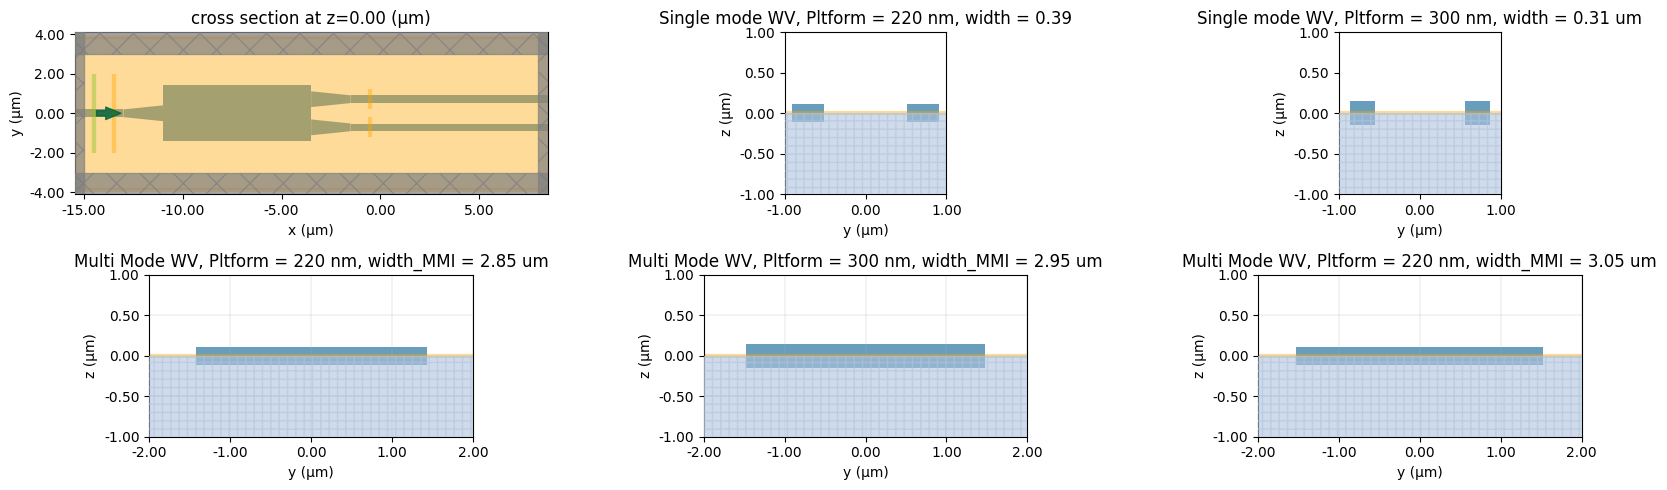

In [74]:
#------- Primer reto ---------

fig0, axes0 = plt.subplots(2, 3, figsize=(17, 5))
sim[0][0][0].plot(z = 0, lw=1, ax=axes0[0][0]) # Vista superior


sim[0][0][0].plot(x=0, lw=1, ax=axes0[0][1])   # Vista transversal Single mode waveguides a 220 nm , optimizado a 390 nm de width
axes0[0][1].set_xlim([-1, 1])
axes0[0][1].set_ylim([-1, 1])
axes0[0][1].set_title(f"Single mode WV, Pltform = {[220,300][0]} nm, width = {width_220}")


sim[1][0][0].plot(x=0, lw=1, ax=axes0[0][2])   # Vista transversal Single mode waveguides a 300 nm , optimizado a 310 nm de width
axes0[0][2].set_xlim([-1, 1])
axes0[0][2].set_ylim([-1, 1])
axes0[0][2].set_title(f"Single mode WV, Pltform = {[220,300][1]} nm, width = {width_300} um")

sim[0][0][0].plot(x=-5, lw=1, ax=axes0[1][0])
axes0[1][0].set_ylim([-1, 1])
axes0[1][0].set_xlim([-2, 2])
axes0[1][0].grid(True,linewidth = 0.2)
axes0[1][0].set_title(f"Multi Mode WV, Pltform = {[220,300][0]} nm, width_MMI = {sweep_MMI_W[0]} um")


sim[1][0][1].plot(x=-5, lw=1, ax=axes0[1][1])
axes0[1][1].set_ylim([-1, 1])
axes0[1][1].set_xlim([-2, 2])
axes0[1][1].grid(True,linewidth = 0.2)
axes0[1][1].set_title(f"Multi Mode WV, Pltform = {[220,300][1]} nm, width_MMI = {sweep_MMI_W[1]} um")


sim[0][0][2].plot(x=-5, lw=1, ax=axes0[1][2])
axes0[1][2].set_ylim([-1, 1])
axes0[1][2].set_xlim([-2, 2])
axes0[1][2].grid(True,linewidth = 0.2)
axes0[1][2].set_title(f"Multi Mode WV, Pltform = {[220,300][0]} nm, width_MMI = {sweep_MMI_W[2]} um")

plt.tight_layout()
plt.show()

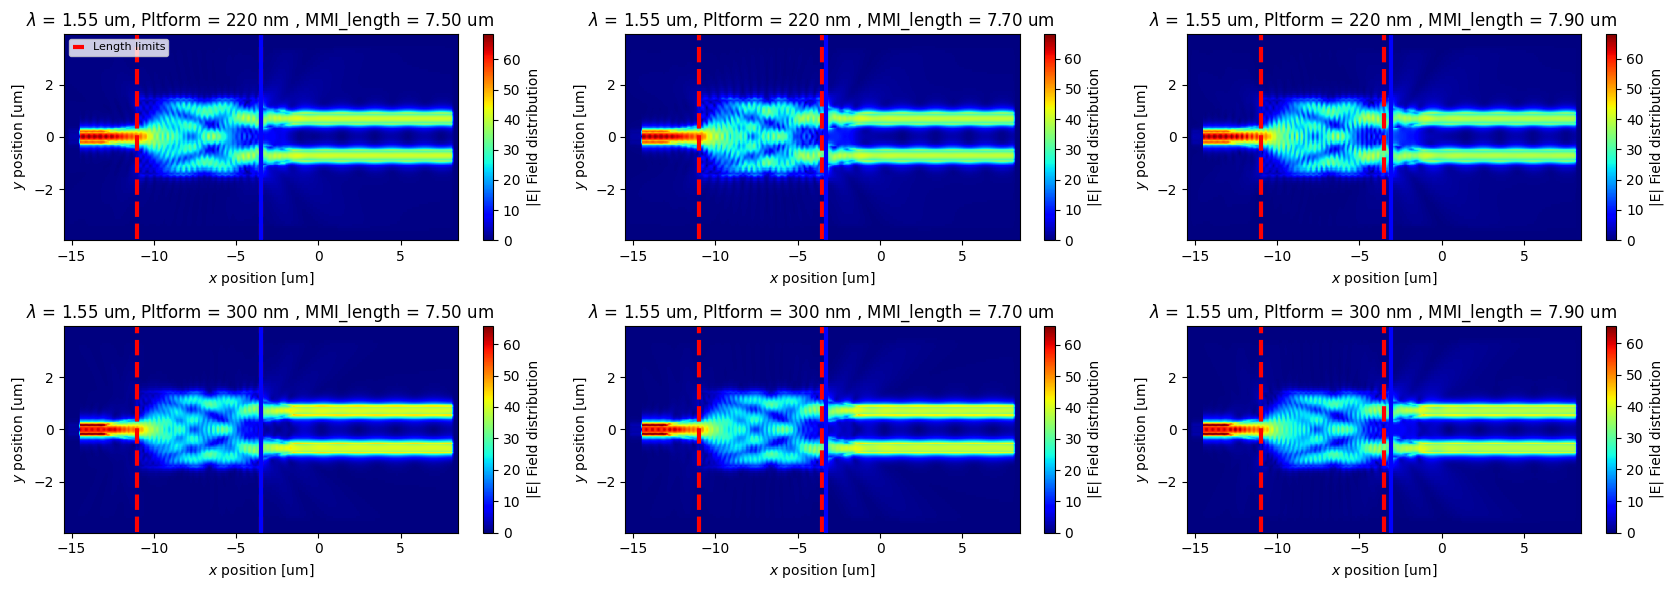

In [75]:
# Firts Task
fig1, axes1 = plt.subplots(2, 3, figsize=(17, 6))

wv_fixed = 24
length_fixed = 0
width_fixed = 0

for thick_idx in range(2):
    for length_idx in range(MMI_L_points-1):

        Ex_L = Longitudinal[thick_idx][length_idx][width_fixed].Ex.abs.isel(f = wv_fixed).squeeze()
        Ey_L = Longitudinal[thick_idx][length_idx][width_fixed].Ey.abs.isel(f = wv_fixed).squeeze()
        Ez_L = Longitudinal[thick_idx][length_idx][width_fixed].Ez.abs.isel(f = wv_fixed).squeeze()
        E_L = np.sqrt(np.abs(Ex_L)**2 + np.abs(Ey_L)**2 + np.abs(Ez_L)**2)

        x_L = Ex_L.coords['x'].values
        y_L = Ex_L.coords['y'].values


        im = axes1[thick_idx][length_idx].pcolormesh(
                x_L,
                y_L,
                E_L.T,
                shading='auto',
                cmap='jet'
        )

        axes1[thick_idx][length_idx].set_title(fr"$\lambda$ = {td.C_0/sweep_freq[wv_fixed]:.2f} um, Pltform = {[220,300][thick_idx]} nm , MMI_length = {sweep_MMI_L[length_idx]:.2f} um ")
        axes1[thick_idx][length_idx].set_xlabel(r"$x$ position [um]")
        axes1[thick_idx][length_idx].set_ylabel(r"$y$ position [um]")
        plt.colorbar(im, ax=axes1[thick_idx][length_idx]).set_label("|E| Field distribution")
        axes1[thick_idx][length_idx].plot(np.ones(len(y_L))*(-11),y_L, lw = 3 ,color = "red", linestyle = "--" , label = "Length limits")
        axes1[thick_idx][length_idx].plot(np.ones(len(y_L))*(sweep_MMI_L[0]-11),y_L, lw = 3 ,color = "red",linestyle = "--")
        axes1[thick_idx][length_idx].plot(np.ones(len(y_L))*(sweep_MMI_L[length_idx]-11),y_L, lw = 3 ,color = "blue",linestyle = "-" )


axes1[0][0].legend(loc = "upper left",fontsize=8,handlelength=1,borderpad=0.3,labelspacing=0.3)
plt.tight_layout()
plt.show()

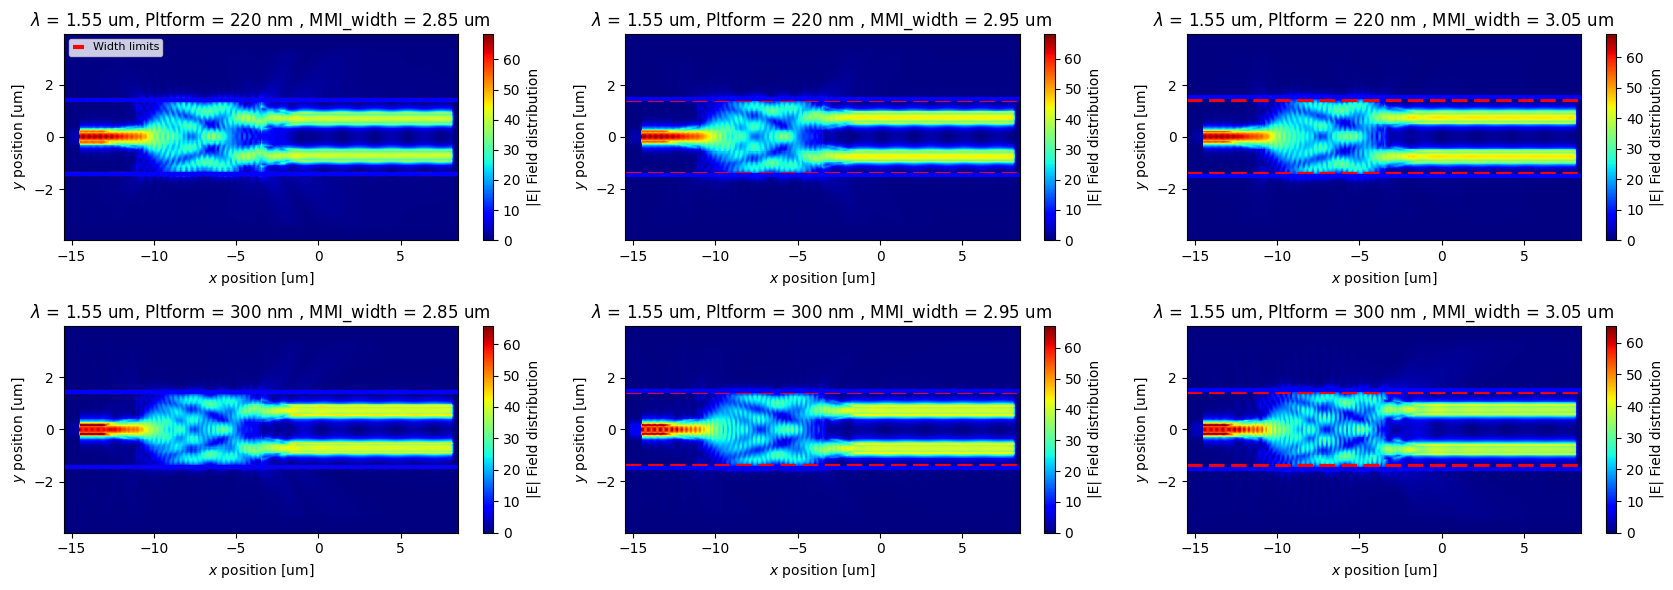

In [76]:
fig2, axes2 = plt.subplots(2, 3, figsize=(17, 6))

wv_fixed = 24
length_fixed = 0
width_fixed = 0

for thick_idx in range(2):
    for width_idx in range(MMI_W_points-1):

        Ex_L = Longitudinal[thick_idx][length_fixed][width_idx].Ex.abs.isel(f = wv_fixed).squeeze()
        Ey_L = Longitudinal[thick_idx][length_fixed][width_idx].Ey.abs.isel(f = wv_fixed).squeeze()
        Ez_L = Longitudinal[thick_idx][length_fixed][width_idx].Ez.abs.isel(f = wv_fixed).squeeze()
        E_L = np.sqrt(Ex_L**2+Ey_L**2+Ez_L**2)

        x_L = Ey_L.coords['x'].values
        y_L = Ey_L.coords['y'].values


        im = axes2[thick_idx][width_idx].pcolormesh(
            x_L,
            y_L,
            E_L.T,
            shading='auto',
            cmap='jet'
        )

        axes2[thick_idx][width_idx].set_title(fr"$\lambda$ = {td.C_0/sweep_freq[wv_fixed]:.2f} um, Pltform = {[220,300][thick_idx]} nm , MMI_width = {sweep_MMI_W[width_idx]:.2f} um ")
        axes2[thick_idx][width_idx].set_xlabel(r"$x$ position [um]")
        axes2[thick_idx][width_idx].set_ylabel(r"$y$ position [um]")
        plt.colorbar(im, ax=axes2[thick_idx][width_idx]).set_label("|E| Field distribution")
        axes2[thick_idx][width_idx].plot(x_L,np.ones(len(x_L))*(sweep_MMI_W[width_fixed]/2), lw = 3 ,color = "red", linestyle = "--" , label = "Width limits")
        axes2[thick_idx][width_idx].plot(x_L,np.ones(len(x_L))*(-sweep_MMI_W[width_fixed]/2), lw = 3 ,color = "red",linestyle = "--")
        axes2[thick_idx][width_idx].plot(x_L,np.ones(len(x_L))*(sweep_MMI_W[width_idx]/2), lw = 3 ,color = "blue",linestyle = "-" )
        axes2[thick_idx][width_idx].plot(x_L,np.ones(len(x_L))*(-sweep_MMI_W[width_idx]/2), lw = 3 ,color = "blue",linestyle = "-" )


axes2[0][0].legend(loc = "upper left",fontsize=8,handlelength=1,borderpad=0.3,labelspacing=0.3)


plt.tight_layout()
plt.show()

IndexError: list index out of range

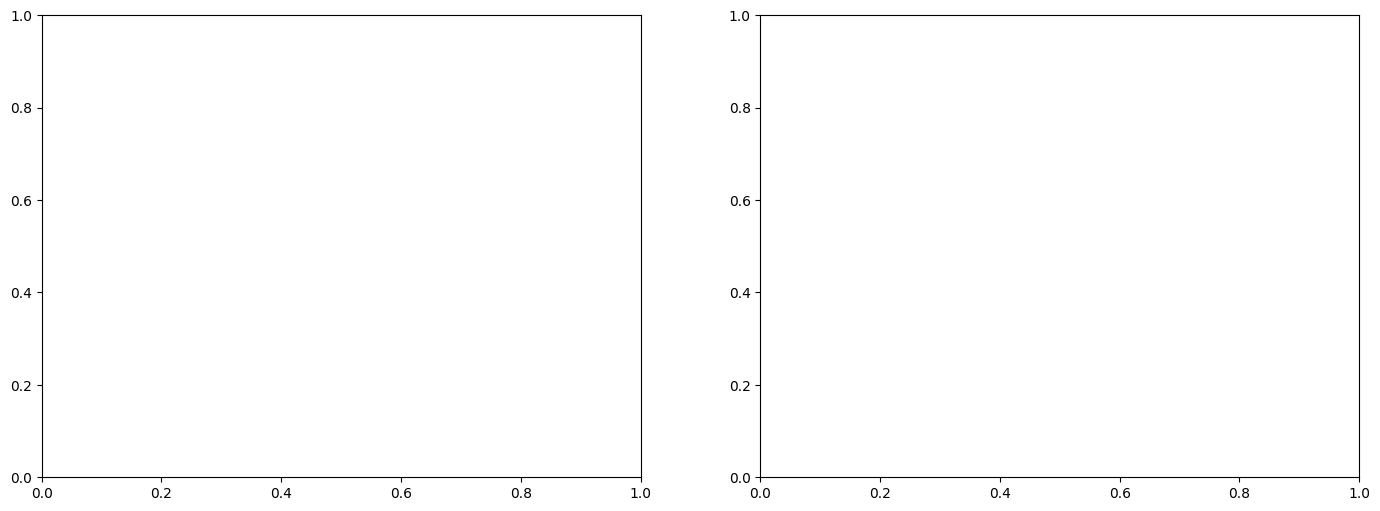

In [125]:
## Optimizaremos para los 4 puntos de sweep tanto en largo como en ancho a ver si encontramos un nuevo valor mejorado para los encontrados
import math


fig3, axes3 = plt.subplots(1, 2, figsize=(17, 6))

Splitting_ratio_OUT1 = np.zeros(MMI_W_points)
Splitting_ratio_OUT2 = np.zeros(MMI_W_points)
width_fixed = 2 # Valor ms cercano al optimizado 3 um
length_fixed = 1 # valor mas cercano al optimizado 7.8 um
wv_fixed = 24 # a 1550 nm

Losses_220 = np.zeros(MMI_W_points)
Losses_300 = np.zeros(MMI_W_points)
width_idx = 0

for thick_idx in range(2):
    for width_idx in range(MMI_W_points):

        ## Calculo de potencia para el monitor de entrada

        Ey_INR = IN[thick_idx][length_fixed][width_idx].Ey.isel(f = wv_fixed).squeeze() # La componente real Ey a 1550 nm
        Ez_INR = IN[thick_idx][length_fixed][width_idx].Ez.isel(f = wv_fixed).squeeze() # La componente real Ez a 1550 nm

        Hy_INR = IN[thick_idx][length_fixed][width_idx].Hy.isel(f = wv_fixed).squeeze() # La componente real Hy a 1550 nm
        Hz_INR = IN[thick_idx][length_fixed][width_idx].Hz.isel(f = wv_fixed).squeeze() # La componente real Hz a 1550 nm

        Sx_INR = 0.5 * np.real(Ey_INR * np.conj(Hz_INR) - Ez_INR * np.conj(Hy_INR))

        arr_Sx_INR = Sx_INR.values

        x_coords_IN = Ey_INR.coords['y'].values
        y_coords_IN = Ey_INR.coords['z'].values

        dx = np.diff(x_coords_IN).mean()
        dy = np.diff(y_coords_IN).mean()

        P_IN= np.sum(arr_Sx_INR) * dx * dy



        ## Vamos a hacer lo mismo para OUT1 y OUT2


        Ey_OUT1R = OUT1[thick_idx][length_fixed][width_idx].Ey.isel(f = wv_fixed).squeeze() # La componente real Ey a 1550 nm
        Ez_OUT1R = OUT1[thick_idx][length_fixed][width_idx].Ez.isel(f = wv_fixed).squeeze() # La componente real Ez a 1550 nm

        Hy_OUT1R = OUT1[thick_idx][length_fixed][width_idx].Hy.isel(f = wv_fixed).squeeze() # La componente real Hy a 1550 nm
        Hz_OUT1R = OUT1[thick_idx][length_fixed][width_idx].Hz.isel(f = wv_fixed).squeeze() # La componente real Hz a 1550 nm

        Sx_OUT1R = 0.5 * np.real(Ey_OUT1R * np.conj(Hz_OUT1R) - Ez_OUT1R * np.conj(Hy_OUT1R))

        arr_Sx_OUT1R = Sx_OUT1R.values

        x_coords_OUT1 = Sx_OUT1R.coords['y'].values
        y_coords_OUT1 = Sx_OUT1R.coords['z'].values

        dx = np.diff(x_coords_OUT1).mean()
        dy = np.diff(y_coords_OUT1).mean()

        P_OUT1= np.sum(arr_Sx_OUT1R) * dx * dy


        # para OUT2


        Ey_OUT2R = OUT2[thick_idx][length_fixed][width_idx].Ey.isel(f = wv_fixed).squeeze() # La componente real Ey a 1550 nm
        Ez_OUT2R = OUT2[thick_idx][length_fixed][width_idx].Ez.isel(f = wv_fixed).squeeze() # La componente real Ez a 1550 nm

        Hy_OUT2R = OUT2[thick_idx][length_fixed][width_idx].Hy.isel(f = wv_fixed).squeeze() # La componente real Hy a 1550 nm
        Hz_OUT2R = OUT2[thick_idx][length_fixed][width_idx].Hz.isel(f = wv_fixed).squeeze() # La componente real Hz a 1550 nm


        Sx_OUT2R = 0.5 * np.real(Ey_OUT2R * np.conj(Hz_OUT2R) - Ez_OUT2R * np.conj(Hy_OUT2R))


        x_coords_OUT2 = Sx_OUT2R.coords['y'].values
        y_coords_OUT2 = Sx_OUT2R.coords['z'].values

        dx = np.diff(x_coords_OUT2).mean()
        dy = np.diff(y_coords_OUT2).mean()

        arr_Sx_OUT2R = Sx_OUT2R.values

        P_OUT2= np.sum(arr_Sx_OUT2R) * dx * dy

        if thick_idx == 0:
            Losses_220[width_idx] = 10*math.log10((P_IN-(P_OUT1+P_OUT2))/P_IN)
        else:
            Losses_300[width_idx] = 10*math.log10((P_IN-(P_OUT1+P_OUT2))/P_IN)


        # Calculamos el Splitting ratio

        Splitting_ratio_OUT1[width_idx] = P_OUT1 *100/P_IN
        Splitting_ratio_OUT2[width_idx] = P_OUT2 *100/P_IN




    axes3[thick_idx].plot(sweep_MMI_W,Splitting_ratio_OUT1, label = "Splitting Ratio Output 1", lw = 2)
    axes3[thick_idx].plot(sweep_MMI_W,Splitting_ratio_OUT2, label = "Splitting Ratio Output 2", linestyle = '--')
    axes3[thick_idx].set_title(f"Splitting Ratio for Pltform = {[220,300][thick_idx]} nm, width sweep, Length = {sweep_MMI_L[length_fixed]:.2f}")
    axes3[thick_idx].set_xlabel(r"MMI width [um]")
    axes3[thick_idx].set_ylabel(r"Splitting Ratio $\%$")
    axes3[thick_idx].legend(loc='best')
    axes3[thick_idx].grid(True, lw = 0.5)


plt.show()

fig_loss0, ax_loss0 = plt.subplots(1,2,figsize=(14,8))


ax_loss0[0].plot(sweep_MMI_W, Losses_220, label="Insertion Loss", linestyle='--')
ax_loss0[0].set_title(
    f"Insertion Loss for Pltform = {[220, 300][0]} nm, Width sweep, length = {sweep_MMI_L[length_fixed]:.2f} um")
ax_loss0[0].set_xlabel(r"MMI width [um]")
ax_loss0[0].set_ylabel(r"Loss (dBs)")
ax_loss0[0].legend(loc='best')
ax_loss0[0].grid(True, lw=0.5)

ax_loss0[1].plot(sweep_MMI_W, Losses_300, label="Insertion Loss", linestyle='--')
ax_loss0[1].set_title(
    f"Insertion Loss for Pltform = {[220, 300][1]} nm, Width sweep, length = {sweep_MMI_L[length_fixed]:.2f} um")
ax_loss0[1].set_xlabel(r"MMI width [um]")
ax_loss0[1].set_ylabel(r"Loss (dBs)")
ax_loss0[1].grid(True, lw=0.5)



plt.show()




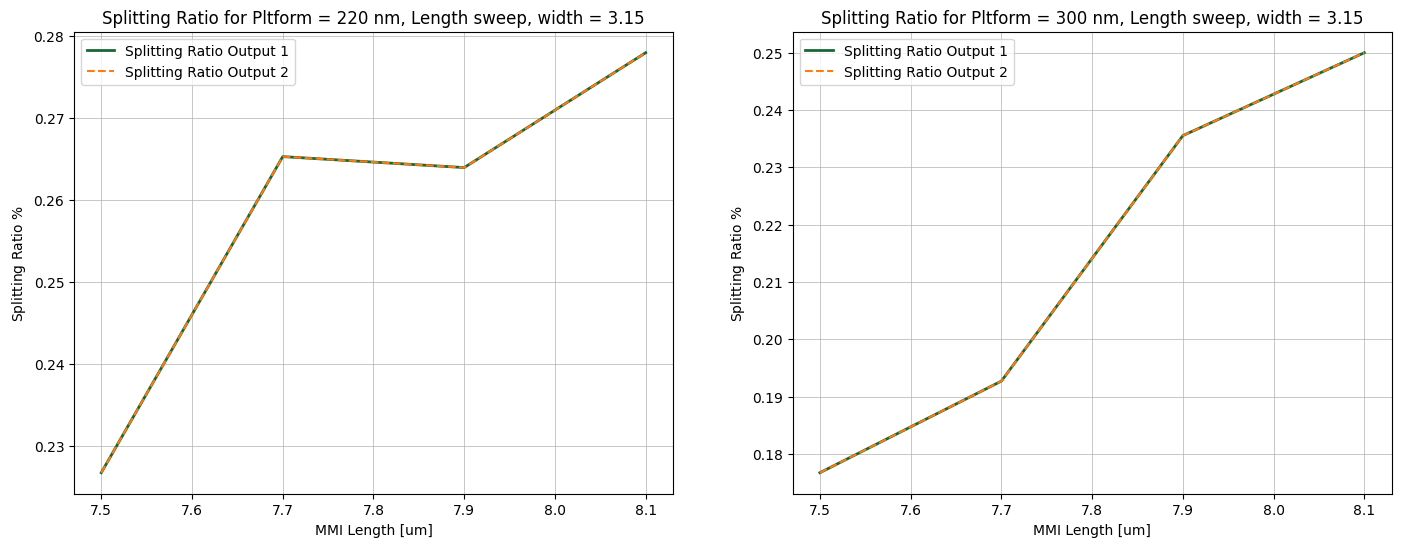

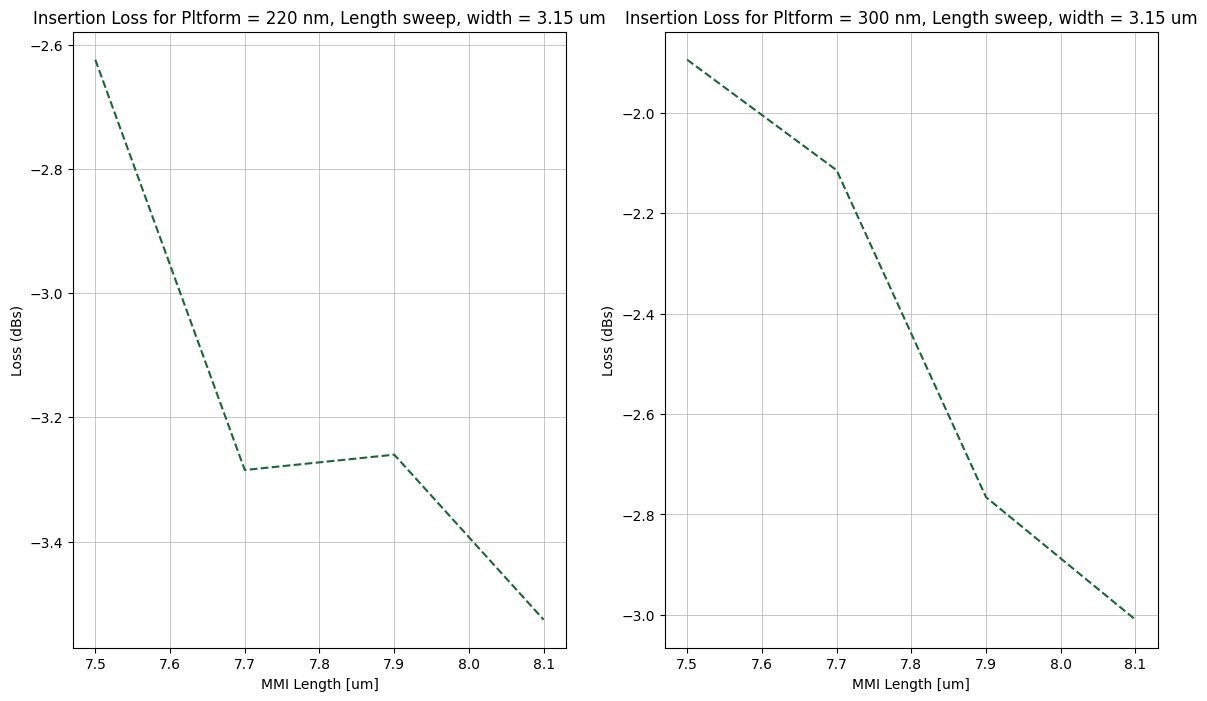

In [106]:
## Optimizaremos para los 4 puntos de sweep tanto en largo como en ancho a ver si encontramos un nuevo valor mejorado para los encontrados
fig4, axes4 = plt.subplots(1, 2, figsize=(17, 6))

Splitting_ratio_OUT1 = np.zeros(MMI_L_points)
Splitting_ratio_OUT2 = np.zeros(MMI_L_points)
width_fixed = 2  # Valor ms cercano al optimizado 3 um
length_fixed = 1  # valor mas cercano al optimizado 7.8 um
wv_fixed = 24  # a 1550 nm
Losses_220 = np.zeros(MMI_L_points)
Losses_300 = np.zeros(MMI_L_points)

for thick_idx in range(2):
    for length_idx in range(MMI_L_points):
        ## Calculo de potencia para el monitor de entrada

        Ey_INR = IN[thick_idx][length_idx][width_fixed].Ey.isel(f=wv_fixed).squeeze()  # La componente real Ey a 1550 nm
        Ez_INR = IN[thick_idx][length_idx][width_fixed].Ez.isel(f=wv_fixed).squeeze()  # La componente real Ez a 1550 nm

        Hy_INR = IN[thick_idx][length_idx][width_fixed].Hy.isel(f=wv_fixed).squeeze()  # La componente real Hy a 1550 nm
        Hz_INR = IN[thick_idx][length_idx][width_fixed].Hz.isel(f=wv_fixed).squeeze()  # La componente real Hz a 1550 nm

        Sx_INR = 0.5 * np.real(Ey_INR * np.conj(Hz_INR) - Ez_INR * np.conj(Hy_INR))

        arr_Sx_INR = Sx_INR.values

        x_coords_IN = Ey_INR.coords['y'].values
        y_coords_IN = Ey_INR.coords['z'].values

        dx = np.diff(x_coords_IN).mean()
        dy = np.diff(y_coords_IN).mean()

        P_IN = np.sum(arr_Sx_INR) * dx * dy

        ## Vamos a hacer lo mismo para OUT1 y OUT2

        Ey_OUT1R = OUT1[thick_idx][length_idx][width_fixed].Ey.isel(
            f=wv_fixed).squeeze()  # La componente real Ey a 1550 nm
        Ez_OUT1R = OUT1[thick_idx][length_idx][width_fixed].Ez.isel(
            f=wv_fixed).squeeze()  # La componente real Ez a 1550 nm

        Hy_OUT1R = OUT1[thick_idx][length_idx][width_fixed].Hy.isel(
            f=wv_fixed).squeeze()  # La componente real Hy a 1550 nm
        Hz_OUT1R = OUT1[thick_idx][length_idx][width_fixed].Hz.isel(
            f=wv_fixed).squeeze()  # La componente real Hz a 1550 nm

        Sx_OUT1R = 0.5 * np.real(Ey_OUT1R * np.conj(Hz_OUT1R) - Ez_OUT1R * np.conj(Hy_OUT1R))

        arr_Sx_OUT1R = Sx_OUT1R.values

        x_coords_OUT1 = Sx_OUT1R.coords['y'].values
        y_coords_OUT1 = Sx_OUT1R.coords['z'].values

        dx = np.diff(x_coords_OUT1).mean()
        dy = np.diff(y_coords_OUT1).mean()

        P_OUT1 = np.sum(arr_Sx_OUT1R) * dx * dy

        # para OUT2

        Ey_OUT2R = OUT2[thick_idx][length_idx][width_fixed].Ey.isel(
            f=wv_fixed).squeeze()  # La componente real Ey a 1550 nm
        Ez_OUT2R = OUT2[thick_idx][length_idx][width_fixed].Ez.isel(
            f=wv_fixed).squeeze()  # La componente real Ez a 1550 nm

        Hy_OUT2R = OUT2[thick_idx][length_idx][width_fixed].Hy.isel(
            f=wv_fixed).squeeze()  # La componente real Hy a 1550 nm
        Hz_OUT2R = OUT2[thick_idx][length_idx][width_fixed].Hz.isel(
            f=wv_fixed).squeeze()  # La componente real Hz a 1550 nm

        Sx_OUT2R = 0.5 * np.real(Ey_OUT2R * np.conj(Hz_OUT2R) - Ez_OUT2R * np.conj(Hy_OUT2R))

        x_coords_OUT2 = Sx_OUT2R.coords['y'].values
        y_coords_OUT2 = Sx_OUT2R.coords['z'].values

        dx = np.diff(x_coords_OUT2).mean()
        dy = np.diff(y_coords_OUT2).mean()

        arr_Sx_OUT2R = Sx_OUT2R.values

        P_OUT2 = np.sum(arr_Sx_OUT2R) * dx * dy

        # Calculamos el Splitting ratio

        Splitting_ratio_OUT1[length_idx] = P_OUT1 *100/ P_IN
        Splitting_ratio_OUT2[length_idx] = P_OUT2 *100 / P_IN

        if thick_idx == 0:
            Losses_220[length_idx] = 10*math.log10((P_IN-(P_OUT1+P_OUT2))/P_IN)
        else:
            Losses_300[length_idx] = 10*math.log10((P_IN-(P_OUT1+P_OUT2))/P_IN)

    axes4[thick_idx].plot(sweep_MMI_L, Splitting_ratio_OUT1, label="Splitting Ratio Output 1", lw=2)
    axes4[thick_idx].plot(sweep_MMI_L, Splitting_ratio_OUT2, label="Splitting Ratio Output 2", linestyle='--')
    axes4[thick_idx].set_title(
        f"Splitting Ratio for Pltform = {[220, 300][thick_idx]} nm, Length sweep, width = {sweep_MMI_W[width_fixed]:.2f}")
    axes4[thick_idx].set_xlabel(r"MMI Length [um]")
    axes4[thick_idx].set_ylabel(r"Splitting Ratio $\%$")
    axes4[thick_idx].legend(loc='best')
    axes4[thick_idx].grid(True, lw=0.5)

plt.show()


fig_loss1, ax_loss1 = plt.subplots(1,2,figsize=(14,8))


ax_loss1[0].plot(sweep_MMI_L, Losses_220, label="Insertion Loss", linestyle='--')
ax_loss1[0].set_title(
    f"Insertion Loss for Pltform = {[220, 300][0]} nm, Length sweep, width = {sweep_MMI_W[width_fixed]:.2f} um")
ax_loss1[0].set_xlabel(r"MMI Length [um]")
ax_loss1[0].set_ylabel(r"Loss (dBs)")
ax_loss1[0].grid(True, lw=0.5)

ax_loss1[1].plot(sweep_MMI_L, Losses_300, label="Insertion Loss", linestyle='--')
ax_loss1[1].set_title(
    f"Insertion Loss for Pltform = {[220, 300][1]} nm, Length sweep, width = {sweep_MMI_W[width_fixed]:.2f} um")
ax_loss1[1].set_xlabel(r"MMI Length [um]")
ax_loss1[1].set_ylabel(r"Loss (dBs)")
ax_loss1[1].grid(True, lw=0.5)



plt.show()



## Pra una plataforma tanto de 220 nm como de 300 nm que un rango optimo para obtener un splitting de  aproximada mente en cada salida de entre un 20 y un 30 % se permiten un rango de +- 150 nm para el ancho de MMI y $\pm300$ nm para el largo, tomando mas puntos y haciendo un estudio 2D variandolos dos parametros al mismo tiempo, se podria mejorar tal optimización.

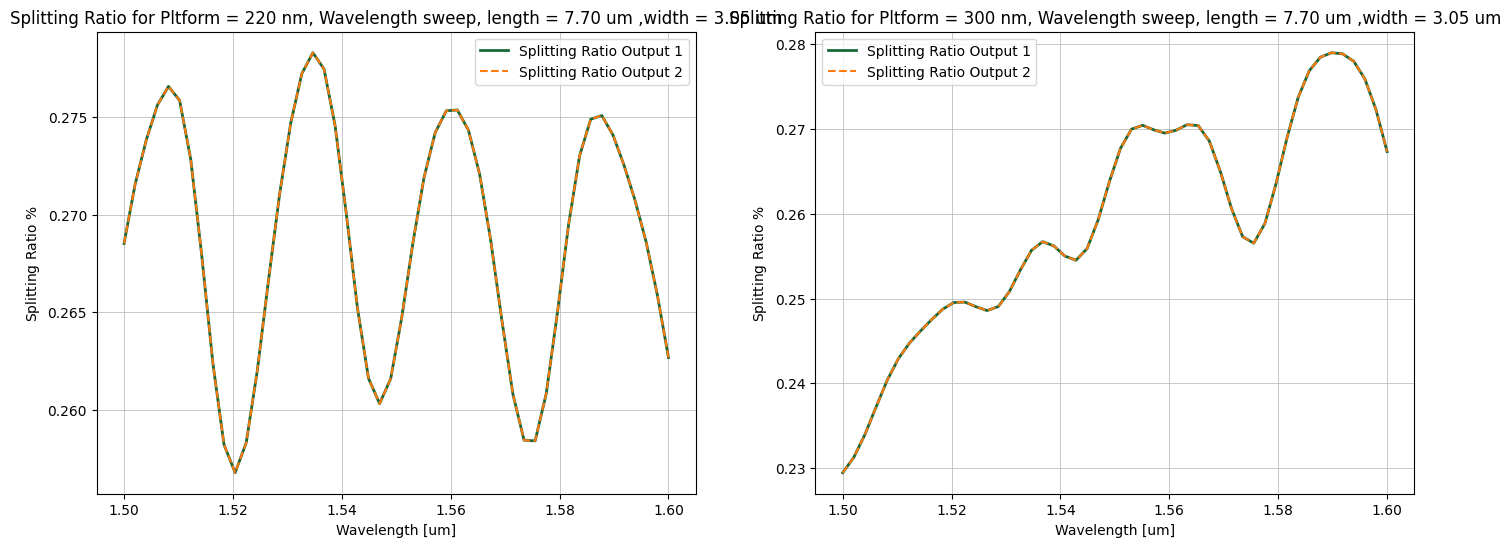

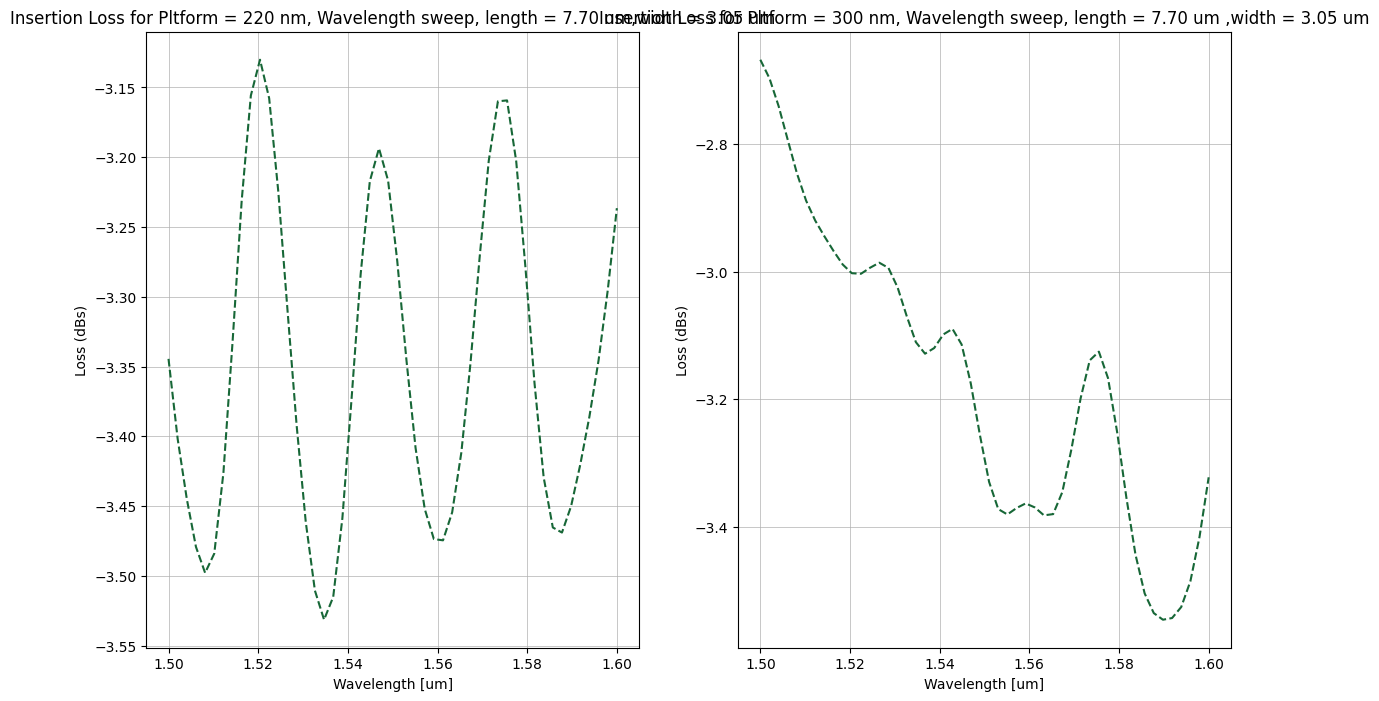

In [114]:
## Usaremos ahora los monitores transversales para hacer el calculo de potencia Usando la componente real del vector de Poyting en x complejo

fig5, axes5 = plt.subplots(1, 2, figsize=(17, 6))

Splitting_ratio_OUT1 = np.zeros(wv_points)
Splitting_ratio_OUT2 = np.zeros(wv_points)
width_fixed = 2  # Valor ms cercano al optimizado 3 um
length_fixed = 1  # valor mas cercano al optimizado 7.8 um
wv_fixed = 24  # a 1550 nm
Losses_220 = np.zeros(wv_points)
Losses_300 = np.zeros(wv_points)

for thick_idx in range(2):
    for wv_idx in range(wv_points):
        ## Calculo de potencia para el monitor de entrada

        Ey_INR = IN[thick_idx][length_fixed][width_fixed].Ey.isel(f=wv_idx).squeeze()  # La componente real Ey
        Ez_INR = IN[thick_idx][length_fixed][width_fixed].Ez.isel(f=wv_idx).squeeze()  # La componente real Ez

        Hy_INR = IN[thick_idx][length_fixed][width_fixed].Hy.isel(f=wv_idx).squeeze()  # La componente real Hy
        Hz_INR = IN[thick_idx][length_fixed][width_fixed].Hz.isel(f=wv_idx).squeeze()  # La componente real Hz

        Sx_INR = 0.5 * np.real(Ey_INR * np.conj(Hz_INR) - Ez_INR * np.conj(Hy_INR))

        arr_Sx_INR = Sx_INR.values

        x_coords_IN = Ey_INR.coords['y'].values
        y_coords_IN = Ey_INR.coords['z'].values

        dx = np.diff(x_coords_IN).mean()
        dy = np.diff(y_coords_IN).mean()

        P_IN = np.sum(arr_Sx_INR) * dx * dy

        ## Vamos a hacer lo mismo para OUT1 y OUT2

        Ey_OUT1R = OUT1[thick_idx][length_fixed][width_fixed].Ey.isel(f=wv_idx).squeeze()  # La componente real Ey a 1550 nm
        Ez_OUT1R = OUT1[thick_idx][length_fixed][width_fixed].Ez.isel(f=wv_idx).squeeze()  # La componente real Ez a 1550 nm

        Hy_OUT1R = OUT1[thick_idx][length_fixed][width_fixed].Hy.isel(f=wv_idx).squeeze()  # La componente real Hy a 1550 nm
        Hz_OUT1R = OUT1[thick_idx][length_fixed][width_fixed].Hz.isel(f=wv_idx).squeeze()  # La componente real Hz a 1550 nm

        Sx_OUT1R = 0.5 * np.real(Ey_OUT1R * np.conj(Hz_OUT1R) - Ez_OUT1R * np.conj(Hy_OUT1R))

        arr_Sx_OUT1R = Sx_OUT1R.values

        x_coords_OUT1 = Sx_OUT1R.coords['y'].values
        y_coords_OUT1 = Sx_OUT1R.coords['z'].values

        dx = np.diff(x_coords_OUT1).mean()
        dy = np.diff(y_coords_OUT1).mean()

        P_OUT1 = np.sum(arr_Sx_OUT1R) * dx * dy

        # para OUT2

        Ey_OUT2R = OUT2[thick_idx][length_fixed][width_fixed].Ey.isel(f=wv_idx).squeeze()  # La componente real Ey a 1550 nm
        Ez_OUT2R = OUT2[thick_idx][length_fixed][width_fixed].Ez.isel(f=wv_idx).squeeze()  # La componente real Ez a 1550 nm

        Hy_OUT2R = OUT2[thick_idx][length_fixed][width_fixed].Hy.isel(f=wv_idx).squeeze()  # La componente real Hy a 1550 nm
        Hz_OUT2R = OUT2[thick_idx][length_fixed][width_fixed].Hz.isel(f=wv_idx).squeeze()  # La componente real Hz a 1550 nm

        Sx_OUT2R = 0.5 * np.real(Ey_OUT2R * np.conj(Hz_OUT2R) - Ez_OUT2R * np.conj(Hy_OUT2R))

        x_coords_OUT2 = Sx_OUT2R.coords['y'].values
        y_coords_OUT2 = Sx_OUT2R.coords['z'].values

        dx = np.diff(x_coords_OUT2).mean()
        dy = np.diff(y_coords_OUT2).mean()

        arr_Sx_OUT2R = Sx_OUT2R.values

        P_OUT2 = np.sum(arr_Sx_OUT2R) * dx * dy

        # Calculamos el Splitting ratio

        Splitting_ratio_OUT1[wv_idx] = P_OUT1 *100/ P_IN
        Splitting_ratio_OUT2[wv_idx] = P_OUT2 *100 / P_IN

        if thick_idx == 0:
            Losses_220[wv_idx] = 10*math.log10((P_IN-(P_OUT1+P_OUT2))/P_IN)
        else:
            Losses_300[wv_idx] = 10*math.log10((P_IN-(P_OUT1+P_OUT2))/P_IN)

    axes5[thick_idx].plot(sweep_wavelength, Splitting_ratio_OUT1, label="Splitting Ratio Output 1", lw=2)
    axes5[thick_idx].plot(sweep_wavelength, Splitting_ratio_OUT2, label="Splitting Ratio Output 2", linestyle='--')
    axes5[thick_idx].set_title(
        f"Splitting Ratio for Pltform = {[220, 300][thick_idx]} nm, Wavelength sweep, length = {sweep_MMI_L[length_fixed]:.2f} um ,width = {sweep_MMI_W[width_fixed]:.2f} um")
    axes5[thick_idx].set_xlabel(r"Wavelength [um]")
    axes5[thick_idx].set_ylabel(r"Splitting Ratio $\%$")
    axes5[thick_idx].legend(loc='best')
    axes5[thick_idx].grid(True, lw=0.5)

plt.show()

fig_loss2, ax_loss2 = plt.subplots(1,2,figsize=(14,8))


ax_loss2[0].plot(sweep_wavelength, Losses_220, label="Insertion Loss", linestyle='--')
ax_loss2[0].set_title(
    f"Insertion Loss for Pltform = {[220, 300][0]} nm, Wavelength sweep, length = {sweep_MMI_L[length_fixed]:.2f} um,width = {sweep_MMI_W[width_fixed]:.2f} um")
ax_loss2[0].set_xlabel(r"Wavelength [um]")
ax_loss2[0].set_ylabel(r"Loss (dBs)")
ax_loss2[0].grid(True, lw=0.5)

ax_loss2[1].plot(sweep_wavelength, Losses_300, label="Insertion Loss", linestyle='--')
ax_loss2[1].set_title(
    f"Insertion Loss for Pltform = {[220, 300][1]} nm, Wavelength sweep, length = {sweep_MMI_L[length_fixed]:.2f} um ,width = {sweep_MMI_W[width_fixed]:.2f} um")
ax_loss2[1].set_xlabel(r"Wavelength [um]")
ax_loss2[1].set_ylabel(r"Loss (dBs)")
ax_loss2[1].grid(True, lw=0.5)



plt.show()


In [117]:
# calculo de tolerancia +- 20 nm width y +-50 nm Length, hacemos ua simulacion de nuevo con nueva data

sim_data_tol, sim_tol = build_MMI_simulation(MMI_length = sweep_MMI_L_tol,MMI_width=sweep_MMI_W_tol,wavelength=sweep_wavelength, dinstance_tapers = dinstance_tapers_tol)


23:03:15 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-d141f59a-0270-4f1d-a947-99f0fa086d
                                        a7' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=717572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d141f59a-0270-4f1d-a947-99f0fa086da7\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=717572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d141f59a-0270-4f1d-a947-99f0fa086da7\ch?]8;;\]8;id=334819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d141f59a-0270-4f1d-a947-99f0fa086da7\taskId]8;;\]8;id=717572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d141f59a-0270-4f1d-a947-99f0fa086da7\=]8;;\]8;id=596962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d141f59a-0270-4f1d-a947-99f0fa086da7\fdve]8;;\]8;id=717572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d141f59a-0270-4f1d-a947-99f0fa086da7\-d141f59a-0270-4f1d-a947-9]8;;\
                                        ]8;id=717572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d141f59a-0270-4f1d-a947-99f0fa086da7\9f0fa086da7']8;;\.

                                        Task folder: ]8;id=610596;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:03:19 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.035.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-2463af20-1704-43bd-9e1d-842772e973
                                        39' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=107644;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=107644;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\ch?]8;;\]8;id=988477;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\taskId]8;;\]8;id=107644;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\=]8;;\]8;id=189011;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\fdve]8;;\]8;id=107644;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\-2463af20-1704-43bd-9e1d-8]8;;\
                                        ]8;id=107644;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\42772e97339']8;;\.

                                        Task folder: ]8;id=732510;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

23:03:21 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.035.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

23:03:23 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

23:03:31 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

23:03:47 Hora est. Pacífico, Sudamérica status = postprocess

23:03:52 Hora est. Pacífico, Sudamérica status = success

23:03:54 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=557345;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=557345;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\ch?]8;;\]8;id=992371;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\taskId]8;;\]8;id=557345;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\=]8;;\]8;id=32854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\fdve]8;;\]8;id=557345;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\-2463af20-1704-43bd-9e1d-8]8;;\
                                        ]8;id=557345;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2463af20-1704-43bd-9e1d-842772e97339\42772e97339']8;;\.

23:04:10 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000321 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-70c91bca-7dc8-4adf-806e-65218c71df
                                        22' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=764541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70c91bca-7dc8-4adf-806e-65218c71df22\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=764541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70c91bca-7dc8-4adf-806e-65218c71df22\ch?]8;;\]8;id=84521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70c91bca-7dc8-4adf-806e-65218c71df22\taskId]8;;\]8;id=764541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70c91bca-7dc8-4adf-806e-65218c71df22\=]8;;\]8;id=311572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70c91bca-7dc8-4adf-806e-65218c71df22\fdve]8;;\]8;id=764541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70c91bca-7dc8-4adf-806e-65218c71df22\-70c91bca-7dc8-4adf-806e-6]8;;\
                                        ]8;id=764541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70c91bca-7dc8-4adf-806e-65218c71df22\5218c71df22']8;;\.

                                        Task folder: ]8;id=814449;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:04:14 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.038.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-4f638a03-2a36-4a8e-b101-93ec488479
                                        7c' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=843885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=843885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\ch?]8;;\]8;id=25233;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\taskId]8;;\]8;id=843885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\=]8;;\]8;id=571118;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\fdve]8;;\]8;id=843885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\-4f638a03-2a36-4a8e-b101-9]8;;\
                                        ]8;id=843885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\3ec4884797c']8;;\.

                                        Task folder: ]8;id=667144;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

23:04:16 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.038.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

23:04:18 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

23:04:26 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

23:04:44 Hora est. Pacífico, Sudamérica status = postprocess

23:04:49 Hora est. Pacífico, Sudamérica status = success

23:04:51 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=877602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=877602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\ch?]8;;\]8;id=796937;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\taskId]8;;\]8;id=877602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\=]8;;\]8;id=522012;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\fdve]8;;\]8;id=877602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\-4f638a03-2a36-4a8e-b101-9]8;;\
                                        ]8;id=877602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f638a03-2a36-4a8e-b101-93ec4884797c\3ec4884797c']8;;\.

23:05:05 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000655 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-2a1152fa-3bc8-4156-901c-1417eea8c2
                                        74' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=651545;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2a1152fa-3bc8-4156-901c-1417eea8c274\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=651545;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2a1152fa-3bc8-4156-901c-1417eea8c274\ch?]8;;\]8;id=70079;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2a1152fa-3bc8-4156-901c-1417eea8c274\taskId]8;;\]8;id=651545;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2a1152fa-3bc8-4156-901c-1417eea8c274\=]8;;\]8;id=841785;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2a1152fa-3bc8-4156-901c-1417eea8c274\fdve]8;;\]8;id=651545;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2a1152fa-3bc8-4156-901c-1417eea8c274\-2a1152fa-3bc8-4156-901c-1]8;;\
                                        ]8;id=651545;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2a1152fa-3bc8-4156-901c-1417eea8c274\417eea8c274']8;;\.

                                        Task folder: ]8;id=333609;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:05:09 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.035.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-c8d97114-54fc-44f3-a9dd-e1daf25f30
                                        9d' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=55946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=55946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\ch?]8;;\]8;id=629031;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\taskId]8;;\]8;id=55946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\=]8;;\]8;id=658969;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\fdve]8;;\]8;id=55946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\-c8d97114-54fc-44f3-a9dd-e]8;;\
                                        ]8;id=55946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\1daf25f309d']8;;\.

                                        Task folder: ]8;id=631988;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

23:05:11 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.035.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

23:05:13 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

23:05:21 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

23:05:37 Hora est. Pacífico, Sudamérica status = postprocess

23:05:42 Hora est. Pacífico, Sudamérica status = success

23:05:44 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=384635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=384635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\ch?]8;;\]8;id=905537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\taskId]8;;\]8;id=384635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\=]8;;\]8;id=847893;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\fdve]8;;\]8;id=384635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\-c8d97114-54fc-44f3-a9dd-e]8;;\
                                        ]8;id=384635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8d97114-54fc-44f3-a9dd-e1daf25f309d\1daf25f309d']8;;\.

23:06:04 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.00037 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-8b582650-4735-4633-8f8c-7c8c5c3fcc
                                        40' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=665827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b582650-4735-4633-8f8c-7c8c5c3fcc40\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=665827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b582650-4735-4633-8f8c-7c8c5c3fcc40\ch?]8;;\]8;id=493511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b582650-4735-4633-8f8c-7c8c5c3fcc40\taskId]8;;\]8;id=665827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b582650-4735-4633-8f8c-7c8c5c3fcc40\=]8;;\]8;id=369051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b582650-4735-4633-8f8c-7c8c5c3fcc40\fdve]8;;\]8;id=665827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b582650-4735-4633-8f8c-7c8c5c3fcc40\-8b582650-4735-4633-8f8c-7]8;;\
                                        ]8;id=665827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b582650-4735-4633-8f8c-7c8c5c3fcc40\c8c5c3fcc40']8;;\.

                                        Task folder: ]8;id=831936;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:06:08 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.038.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-48ec99e8-5437-46fa-8df9-5f72d2fea6
                                        24' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=360540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=360540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\ch?]8;;\]8;id=786393;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\taskId]8;;\]8;id=360540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\=]8;;\]8;id=677530;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\fdve]8;;\]8;id=360540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\-48ec99e8-5437-46fa-8df9-5]8;;\
                                        ]8;id=360540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\f72d2fea624']8;;\.

                                        Task folder: ]8;id=767675;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

23:06:10 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.038.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

23:06:11 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

23:06:20 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

23:06:38 Hora est. Pacífico, Sudamérica status = postprocess

23:06:43 Hora est. Pacífico, Sudamérica status = success

23:06:45 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=961408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=961408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\ch?]8;;\]8;id=242863;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\taskId]8;;\]8;id=961408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\=]8;;\]8;id=845895;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\fdve]8;;\]8;id=961408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\-48ec99e8-5437-46fa-8df9-5]8;;\
                                        ]8;id=961408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec99e8-5437-46fa-8df9-5f72d2fea624\f72d2fea624']8;;\.

23:07:05 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000439 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-13fb0d49-8d9b-4f5e-b319-648c5bb4d5
                                        30' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=211603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13fb0d49-8d9b-4f5e-b319-648c5bb4d530\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=211603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13fb0d49-8d9b-4f5e-b319-648c5bb4d530\ch?]8;;\]8;id=317985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13fb0d49-8d9b-4f5e-b319-648c5bb4d530\taskId]8;;\]8;id=211603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13fb0d49-8d9b-4f5e-b319-648c5bb4d530\=]8;;\]8;id=227426;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13fb0d49-8d9b-4f5e-b319-648c5bb4d530\fdve]8;;\]8;id=211603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13fb0d49-8d9b-4f5e-b319-648c5bb4d530\-13fb0d49-8d9b-4f5e-b319-6]8;;\
                                        ]8;id=211603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13fb0d49-8d9b-4f5e-b319-648c5bb4d530\48c5bb4d530']8;;\.

                                        Task folder: ]8;id=799614;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:07:09 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.035.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-6a476fbc-d8c8-4268-b3f3-9032385c26
                                        ca' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=638445;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=638445;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\ch?]8;;\]8;id=256122;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\taskId]8;;\]8;id=638445;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\=]8;;\]8;id=220264;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\fdve]8;;\]8;id=638445;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\-6a476fbc-d8c8-4268-b3f3-9]8;;\
                                        ]8;id=638445;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\032385c26ca']8;;\.

                                        Task folder: ]8;id=508984;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

23:07:11 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.035.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

23:07:13 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

23:07:21 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

23:07:28 Hora est. Pacífico, Sudamérica status = postprocess

23:07:36 Hora est. Pacífico, Sudamérica status = success

23:07:38 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=915523;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=915523;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\ch?]8;;\]8;id=402322;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\taskId]8;;\]8;id=915523;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\=]8;;\]8;id=771041;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\fdve]8;;\]8;id=915523;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\-6a476fbc-d8c8-4268-b3f3-9]8;;\
                                        ]8;id=915523;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a476fbc-d8c8-4268-b3f3-9032385c26ca\032385c26ca']8;;\.

23:07:48 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000676 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-7107c77b-ffe6-4228-a263-3da113023e
                                        34' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=530775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7107c77b-ffe6-4228-a263-3da113023e34\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=530775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7107c77b-ffe6-4228-a263-3da113023e34\ch?]8;;\]8;id=295178;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7107c77b-ffe6-4228-a263-3da113023e34\taskId]8;;\]8;id=530775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7107c77b-ffe6-4228-a263-3da113023e34\=]8;;\]8;id=706366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7107c77b-ffe6-4228-a263-3da113023e34\fdve]8;;\]8;id=530775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7107c77b-ffe6-4228-a263-3da113023e34\-7107c77b-ffe6-4228-a263-3]8;;\
                                        ]8;id=530775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7107c77b-ffe6-4228-a263-3da113023e34\da113023e34']8;;\.

                                        Task folder: ]8;id=905570;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:07:52 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.037.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61
                                        bb' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=984446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=984446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\ch?]8;;\]8;id=595391;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\taskId]8;;\]8;id=984446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\=]8;;\]8;id=860286;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\fdve]8;;\]8;id=984446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\-0c01bcf1-8abb-4bc5-a563-6]8;;\
                                        ]8;id=984446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\5e889dd61bb']8;;\.

                                        Task folder: ]8;id=935517;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

23:07:54 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.037.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

23:07:56 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

23:08:04 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

23:08:22 Hora est. Pacífico, Sudamérica status = postprocess

23:08:27 Hora est. Pacífico, Sudamérica status = success

23:08:29 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=64236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=64236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\ch?]8;;\]8;id=832265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\taskId]8;;\]8;id=64236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\=]8;;\]8;id=478309;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\fdve]8;;\]8;id=64236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\-0c01bcf1-8abb-4bc5-a563-6]8;;\
                                        ]8;id=64236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c01bcf1-8abb-4bc5-a563-65e889dd61bb\5e889dd61bb']8;;\.

23:08:48 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000809 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-a3ced419-9889-4454-b8f6-03a6d440e7
                                        85' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=199599;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3ced419-9889-4454-b8f6-03a6d440e785\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=199599;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3ced419-9889-4454-b8f6-03a6d440e785\ch?]8;;\]8;id=110907;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3ced419-9889-4454-b8f6-03a6d440e785\taskId]8;;\]8;id=199599;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3ced419-9889-4454-b8f6-03a6d440e785\=]8;;\]8;id=728919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3ced419-9889-4454-b8f6-03a6d440e785\fdve]8;;\]8;id=199599;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3ced419-9889-4454-b8f6-03a6d440e785\-a3ced419-9889-4454-b8f6-0]8;;\
                                        ]8;id=199599;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a3ced419-9889-4454-b8f6-03a6d440e785\3a6d440e785']8;;\.

                                        Task folder: ]8;id=354484;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:08:52 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.035.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-c03a8fb1-7398-4580-a464-578fdb2d3f
                                        8e' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=468902;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=468902;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\ch?]8;;\]8;id=421952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\taskId]8;;\]8;id=468902;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\=]8;;\]8;id=236076;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\fdve]8;;\]8;id=468902;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\-c03a8fb1-7398-4580-a464-5]8;;\
                                        ]8;id=468902;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\78fdb2d3f8e']8;;\.

                                        Task folder: ]8;id=987585;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

23:08:54 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.035.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

23:08:56 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

23:09:04 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

23:09:16 Hora est. Pacífico, Sudamérica status = postprocess

23:09:21 Hora est. Pacífico, Sudamérica status = success

23:09:23 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=457527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=457527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\ch?]8;;\]8;id=518519;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\taskId]8;;\]8;id=457527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\=]8;;\]8;id=225941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\fdve]8;;\]8;id=457527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\-c03a8fb1-7398-4580-a464-5]8;;\
                                        ]8;id=457527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c03a8fb1-7398-4580-a464-578fdb2d3f8e\78fdb2d3f8e']8;;\.

23:09:42 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000783 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-81cf5f6a-e86a-4b27-8f35-9672b8f855
                                        b9' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=269516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81cf5f6a-e86a-4b27-8f35-9672b8f855b9\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=269516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81cf5f6a-e86a-4b27-8f35-9672b8f855b9\ch?]8;;\]8;id=912072;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81cf5f6a-e86a-4b27-8f35-9672b8f855b9\taskId]8;;\]8;id=269516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81cf5f6a-e86a-4b27-8f35-9672b8f855b9\=]8;;\]8;id=293854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81cf5f6a-e86a-4b27-8f35-9672b8f855b9\fdve]8;;\]8;id=269516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81cf5f6a-e86a-4b27-8f35-9672b8f855b9\-81cf5f6a-e86a-4b27-8f35-9]8;;\
                                        ]8;id=269516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-81cf5f6a-e86a-4b27-8f35-9672b8f855b9\672b8f855b9']8;;\.

                                        Task folder: ]8;id=861328;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:09:45 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.037.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

23:09:46 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-2b81b713-9625-4736-9d6e-948ab646c5
                                        31' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=517258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=517258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\ch?]8;;\]8;id=356104;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\taskId]8;;\]8;id=517258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\=]8;;\]8;id=384498;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\fdve]8;;\]8;id=517258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\-2b81b713-9625-4736-9d6e-9]8;;\
                                        ]8;id=517258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\48ab646c531']8;;\.

                                        Task folder: ]8;id=671504;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

23:09:48 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.037.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

23:09:49 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

23:09:55 Hora est. Pacífico, Sudamérica status = preprocess

23:10:00 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

23:10:12 Hora est. Pacífico, Sudamérica status = postprocess

23:10:18 Hora est. Pacífico, Sudamérica status = success

23:10:20 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=393007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=393007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\ch?]8;;\]8;id=94035;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\taskId]8;;\]8;id=393007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\=]8;;\]8;id=667830;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\fdve]8;;\]8;id=393007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\-2b81b713-9625-4736-9d6e-9]8;;\
                                        ]8;id=393007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b81b713-9625-4736-9d6e-948ab646c531\48ab646c531']8;;\.

23:10:30 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000637 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

Estimated Maximum Cost: 0.28942714279742565


In [118]:
## Con la nueva info hacemos de nuevo las curvas de Splitting ratio Vs width, length, y con ello sacamos un estimado de la sensibilidad de la estructura fotonica

IN_tol, OUT1_tol, Longitudinal_tol, OUT2_tol = [[[]],[[]]],[[[]],[[]]],[[[]],[[]]],[[[]],[[]]]

for thick_idx in range(2):
    for length_idx in range(MMI_L_points_tol):
        for width_idx in range(MMI_W_points_tol):
            IN_tol[thick_idx][length_idx].append(sim_data_tol[thick_idx][length_idx][width_idx]["IN"])
            OUT1_tol[thick_idx][length_idx].append(sim_data_tol[thick_idx][length_idx][width_idx]["OUT1"])
            Longitudinal_tol[thick_idx][length_idx].append(sim_data_tol[thick_idx][length_idx][width_idx]["Longitudinal"])
            OUT2_tol[thick_idx][length_idx].append(sim_data_tol[thick_idx][length_idx][width_idx]["OUT2"])

        IN_tol[thick_idx].append([])
        OUT1_tol[thick_idx].append([])
        Longitudinal_tol[thick_idx].append([])
        OUT2_tol[thick_idx].append([])



Para el estudio de la sensibilidad , se ha calculado una variación de 20nm para el ancho, resultando en : -0.229 %/um, Para una plataforma de : 220
Para el estudio de la sensibilidad , se ha calculado una variación de 20nm para el ancho, resultando en : -0.675 %/um, Para una plataforma de : 300


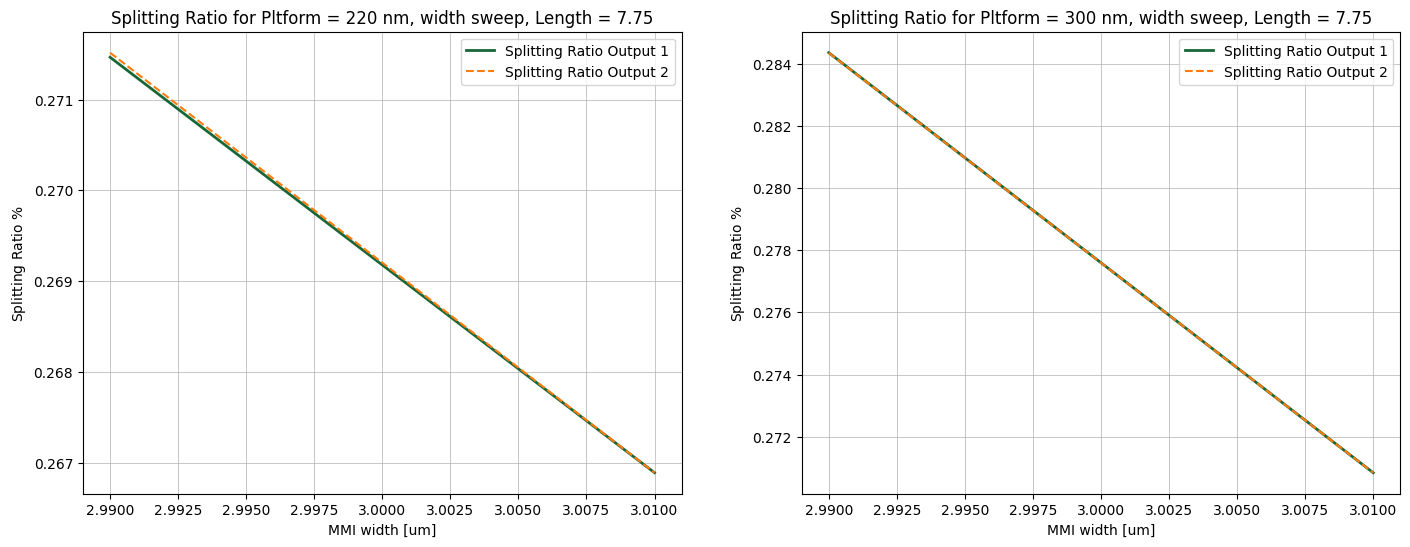

In [119]:


fig6, axes6 = plt.subplots(1, 2, figsize=(17, 6))

Splitting_ratio_OUT1 = np.zeros(MMI_W_points_tol)
Splitting_ratio_OUT2 = np.zeros(MMI_W_points_tol)
width_fixed = 0 # Valor ms cercano al optimizado 3 um
length_fixed = 0 # valor mas cercano al optimizado 7.8 um
wv_fixed = 24 # a 1550 nm


for thick_idx in range(2):
    for width_idx in range(MMI_W_points_tol):

        ## Calculo de potencia para el monitor de entrada

        Ey_INR = IN_tol[thick_idx][length_fixed][width_idx].Ey.isel(f = wv_fixed).squeeze() # La componente real Ey a 1550 nm
        Ez_INR = IN_tol[thick_idx][length_fixed][width_idx].Ez.isel(f = wv_fixed).squeeze() # La componente real Ez a 1550 nm

        Hy_INR = IN_tol[thick_idx][length_fixed][width_idx].Hy.isel(f = wv_fixed).squeeze() # La componente real Hy a 1550 nm
        Hz_INR = IN_tol[thick_idx][length_fixed][width_idx].Hz.isel(f = wv_fixed).squeeze() # La componente real Hz a 1550 nm

        Sx_INR = 0.5 * np.real(Ey_INR * np.conj(Hz_INR) - Ez_INR * np.conj(Hy_INR))

        arr_Sx_INR = Sx_INR.values

        x_coords_IN = Ey_INR.coords['y'].values
        y_coords_IN = Ey_INR.coords['z'].values

        dx = np.diff(x_coords_IN).mean()
        dy = np.diff(y_coords_IN).mean()

        P_IN= np.sum(arr_Sx_INR) * dx * dy



        ## Vamos a hacer lo mismo para OUT1 y OUT2


        Ey_OUT1R = OUT1_tol[thick_idx][length_fixed][width_idx].Ey.isel(f = wv_fixed).squeeze() # La componente real Ey a 1550 nm
        Ez_OUT1R = OUT1_tol[thick_idx][length_fixed][width_idx].Ez.isel(f = wv_fixed).squeeze() # La componente real Ez a 1550 nm

        Hy_OUT1R = OUT1_tol[thick_idx][length_fixed][width_idx].Hy.isel(f = wv_fixed).squeeze() # La componente real Hy a 1550 nm
        Hz_OUT1R = OUT1_tol[thick_idx][length_fixed][width_idx].Hz.isel(f = wv_fixed).squeeze() # La componente real Hz a 1550 nm

        Sx_OUT1R = 0.5 * np.real(Ey_OUT1R * np.conj(Hz_OUT1R) - Ez_OUT1R * np.conj(Hy_OUT1R))

        arr_Sx_OUT1R = Sx_OUT1R.values

        x_coords_OUT1 = Sx_OUT1R.coords['y'].values
        y_coords_OUT1 = Sx_OUT1R.coords['z'].values

        dx = np.diff(x_coords_OUT1).mean()
        dy = np.diff(y_coords_OUT1).mean()

        P_OUT1= np.sum(arr_Sx_OUT1R) * dx * dy


        # para OUT2


        Ey_OUT2R = OUT2_tol[thick_idx][length_fixed][width_idx].Ey.isel(f = wv_fixed).squeeze() # La componente real Ey a 1550 nm
        Ez_OUT2R = OUT2_tol[thick_idx][length_fixed][width_idx].Ez.isel(f = wv_fixed).squeeze() # La componente real Ez a 1550 nm

        Hy_OUT2R = OUT2_tol[thick_idx][length_fixed][width_idx].Hy.isel(f = wv_fixed).squeeze() # La componente real Hy a 1550 nm
        Hz_OUT2R = OUT2_tol[thick_idx][length_fixed][width_idx].Hz.isel(f = wv_fixed).squeeze() # La componente real Hz a 1550 nm


        Sx_OUT2R = 0.5 * np.real(Ey_OUT2R * np.conj(Hz_OUT2R) - Ez_OUT2R * np.conj(Hy_OUT2R))


        x_coords_OUT2 = Sx_OUT2R.coords['y'].values
        y_coords_OUT2 = Sx_OUT2R.coords['z'].values

        dx = np.diff(x_coords_OUT2).mean()
        dy = np.diff(y_coords_OUT2).mean()

        arr_Sx_OUT2R = Sx_OUT2R.values

        P_OUT2= np.sum(arr_Sx_OUT2R) * dx * dy

        # Calculamos el Splitting ratio

        Splitting_ratio_OUT1[width_idx] = P_OUT1/P_IN *100
        Splitting_ratio_OUT2[width_idx] = P_OUT2/P_IN *100

    ## Sensitibity estimation

    sens = (Splitting_ratio_OUT1[1]-Splitting_ratio_OUT1[0])/(sweep_MMI_W_tol[1]-sweep_MMI_W_tol[0])

    print(f"Para el estudio de la sensibilidad , se ha calculado una variación de 20nm para el ancho, resultando en : {sens:.3f} %/um, Para una plataforma de : {[220,300][thick_idx]}")



    axes6[thick_idx].plot(sweep_MMI_W_tol,Splitting_ratio_OUT1, label = "Splitting Ratio Output 1", lw = 2)
    axes6[thick_idx].plot(sweep_MMI_W_tol,Splitting_ratio_OUT2, label = "Splitting Ratio Output 2", linestyle = '--')
    axes6[thick_idx].set_title(f"Splitting Ratio for Pltform = {[220,300][thick_idx]} nm, width sweep, Length = {sweep_MMI_L_tol[length_fixed]:.2f}")
    axes6[thick_idx].set_xlabel(r"MMI width [um]")
    axes6[thick_idx].set_ylabel(r"Splitting Ratio $\%$")
    axes6[thick_idx].legend(loc='best')
    axes6[thick_idx].grid(True, lw = 0.5)

plt.show()



Para el estudio de la sensibilidad , se ha calculado una variación de 50nm para el largo, resultando en : -0.072 %/um, Para una plataforma de : 220 nm
Para el estudio de la sensibilidad , se ha calculado una variación de 50nm para el largo, resultando en : -0.138 %/um, Para una plataforma de : 300 nm


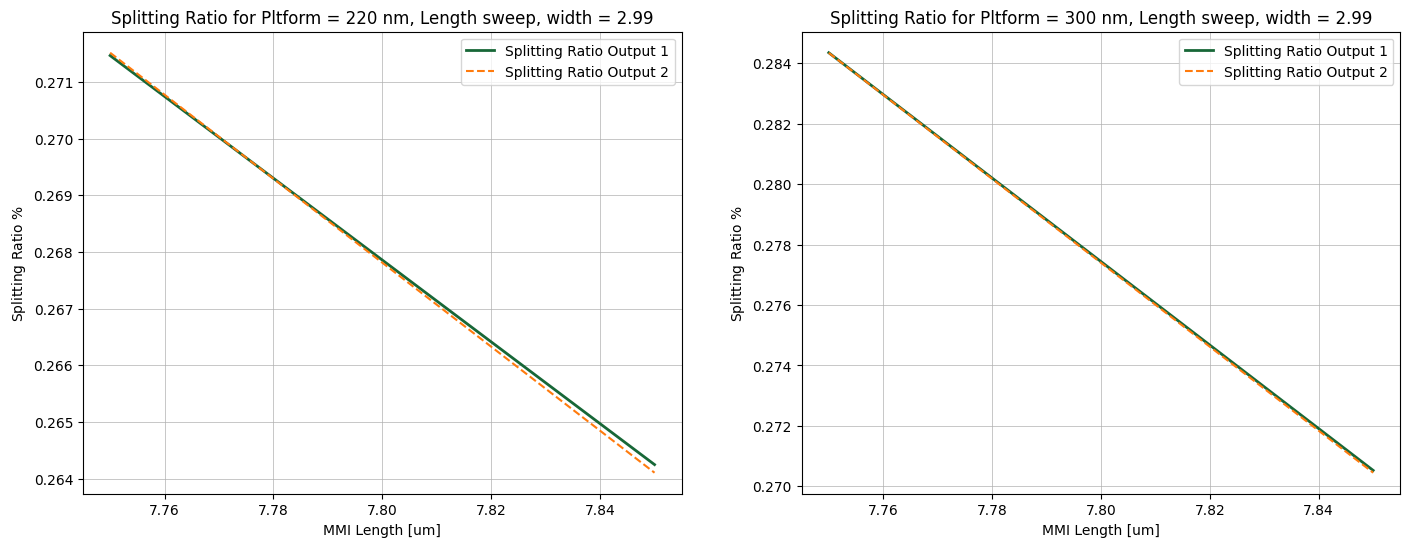

In [123]:
## Ahora para la tolerancia en el largo

fig7, axes7 = plt.subplots(1, 2, figsize=(17, 6))

Splitting_ratio_OUT1 = np.zeros(MMI_L_points_tol)
Splitting_ratio_OUT2 = np.zeros(MMI_L_points_tol)
width_fixed = 0 # Valor ms cercano al optimizado 3 um
length_fixed = 0 # valor mas cercano al optimizado 7.8 um
wv_fixed = 24 # a 1550 nm

for thick_idx in range(2):
    for length_idx in range(MMI_L_points_tol):
        ## Calculo de potencia para el monitor de entrada

        Ey_INR = IN[thick_idx][length_idx][width_fixed].Ey.isel(f=wv_fixed).squeeze()  # La componente real Ey a 1550 nm
        Ez_INR = IN[thick_idx][length_idx][width_fixed].Ez.isel(f=wv_fixed).squeeze()  # La componente real Ez a 1550 nm

        Hy_INR = IN[thick_idx][length_idx][width_fixed].Hy.isel(f=wv_fixed).squeeze()  # La componente real Hy a 1550 nm
        Hz_INR = IN[thick_idx][length_idx][width_fixed].Hz.isel(f=wv_fixed).squeeze()  # La componente real Hz a 1550 nm

        Sx_INR = 0.5 * np.real(Ey_INR * np.conj(Hz_INR) - Ez_INR * np.conj(Hy_INR))

        arr_Sx_INR = Sx_INR.values

        x_coords_IN = Ey_INR.coords['y'].values
        y_coords_IN = Ey_INR.coords['z'].values

        dx = np.diff(x_coords_IN).mean()
        dy = np.diff(y_coords_IN).mean()

        P_IN = np.sum(arr_Sx_INR) * dx * dy

        ## Vamos a hacer lo mismo para OUT1 y OUT2

        Ey_OUT1R = OUT1[thick_idx][length_idx][width_fixed].Ey.isel(f=wv_fixed).squeeze()  # La componente real Ey a 1550 nm
        Ez_OUT1R = OUT1[thick_idx][length_idx][width_fixed].Ez.isel(f=wv_fixed).squeeze()  # La componente real Ez a 1550 nm

        Hy_OUT1R = OUT1[thick_idx][length_idx][width_fixed].Hy.isel(f=wv_fixed).squeeze()  # La componente real Hy a 1550 nm
        Hz_OUT1R = OUT1[thick_idx][length_idx][width_fixed].Hz.isel(f=wv_fixed).squeeze()  # La componente real Hz a 1550 nm

        Sx_OUT1R = 0.5 * np.real(Ey_OUT1R * np.conj(Hz_OUT1R) - Ez_OUT1R * np.conj(Hy_OUT1R))

        arr_Sx_OUT1R = Sx_OUT1R.values

        x_coords_OUT1 = Sx_OUT1R.coords['y'].values
        y_coords_OUT1 = Sx_OUT1R.coords['z'].values

        dx = np.diff(x_coords_OUT1).mean()
        dy = np.diff(y_coords_OUT1).mean()

        P_OUT1 = np.sum(arr_Sx_OUT1R) * dx * dy

        # para OUT2

        Ey_OUT2R = OUT2[thick_idx][length_idx][width_fixed].Ey.isel(f=wv_fixed).squeeze()  # La componente real Ey a 1550 nm
        Ez_OUT2R = OUT2[thick_idx][length_idx][width_fixed].Ez.isel(f=wv_fixed).squeeze()  # La componente real Ez a 1550 nm

        Hy_OUT2R = OUT2[thick_idx][length_idx][width_fixed].Hy.isel(f=wv_fixed).squeeze()  # La componente real Hy a 1550 nm
        Hz_OUT2R = OUT2[thick_idx][length_idx][width_fixed].Hz.isel(f=wv_fixed).squeeze()  # La componente real Hz a 1550 nm

        Sx_OUT2R = 0.5 * np.real(Ey_OUT2R * np.conj(Hz_OUT2R) - Ez_OUT2R * np.conj(Hy_OUT2R))

        x_coords_OUT2 = Sx_OUT2R.coords['y'].values
        y_coords_OUT2 = Sx_OUT2R.coords['z'].values

        dx = np.diff(x_coords_OUT2).mean()
        dy = np.diff(y_coords_OUT2).mean()

        arr_Sx_OUT2R = Sx_OUT2R.values

        P_OUT2 = np.sum(arr_Sx_OUT2R) * dx * dy

        # Calculamos el Splitting ratio

        Splitting_ratio_OUT1[length_idx] = P_OUT1 / P_IN
        Splitting_ratio_OUT2[length_idx] = P_OUT2 / P_IN

    ## Sensitibity estimation

    sens = (Splitting_ratio_OUT1[1]-Splitting_ratio_OUT1[0])/(sweep_MMI_L_tol[1]-sweep_MMI_L_tol[0])

    print(f"Para el estudio de la sensibilidad , se ha calculado una variación de 50nm para el largo, resultando en : {sens:.3f} %/um, Para una plataforma de : {[220,300][thick_idx]} nm")


    axes7[thick_idx].plot(sweep_MMI_L_tol, Splitting_ratio_OUT1, label="Splitting Ratio Output 1", lw=2)
    axes7[thick_idx].plot(sweep_MMI_L_tol, Splitting_ratio_OUT2, label="Splitting Ratio Output 2", linestyle='--')
    axes7[thick_idx].set_title(
        f"Splitting Ratio for Pltform = {[220, 300][thick_idx]} nm, Length sweep, width = {sweep_MMI_W_tol[width_fixed]:.2f}")
    axes7[thick_idx].set_xlabel(r"MMI Length [um]")
    axes7[thick_idx].set_ylabel(r"Splitting Ratio $\%$")
    axes7[thick_idx].legend(loc='best')
    axes7[thick_idx].grid(True, lw=0.5)

plt.show()

